### SECTION 1 – Setup and Data Loading

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

# Add project root to path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == "notebooks" else current_dir
sys.path.insert(0, str(project_root))

from src.config import DATA_PATH, PROCESSED_DATA_PATH
from src import data_processing

print(f"Project root: {project_root}")
print(f"Data path: {DATA_PATH}")
print(f"Processed data path: {PROCESSED_DATA_PATH}")

Project root: /Users/brunobrumbrum/car_price_prediction
Data path: /Users/brunobrumbrum/Documents/data/car_price_prediction
Processed data path: /Users/brunobrumbrum/car_price_prediction/data/processed


In [2]:
# Load data
data_dir = Path(os.path.join(DATA_PATH, "le_boncoin_13_oct_2025"))
df_raw = data_processing.load_car_data(data_dir)

# Apply basic cleaning (price, year, km, brand, model)
df = data_processing.clean_car_data(df_raw)

print(f"Shape: {df.shape}")
df.head()

(732427, 35)
🧹 Starting data cleaning pipeline...

1️⃣ Converting data types...
   Original: 732,427 rows
   After conversion: 732,426 rows
   Removed (invalid price): 1

2️⃣ Filtering and grouping brands...
   Removed 63 brands with <50 cars
   Grouped 38 brands into price tiers

3️⃣ Removing antique cars (pre-1990)...
   Removed 14,075 antique cars

4️⃣ Removing 'autre' entries...
   Removed 4,050 'autre' entries

5️⃣ Removing outliers (IQR 1.5× for price, 1.5× for km)...
   Before: 713,413 rows
   After: 691,115 rows
   Removed: 22,298 (3.1%)

✅ Data cleaning completed!
Final dataset: 691,115 rows × 7 columns
Shape: (691115, 7)


price,year,km,brand,model,energie,puissance_din
f64,f64,f64,str,str,str,str
22990.0,2019.0,87000.0,"""other_luxury""","""other_luxury""","""Autre""","""320 Ch"""
17000.0,2023.0,36000.0,"""other_luxury""","""other_luxury""","""Électrique""","""170 Ch"""
194900.0,2025.0,300.0,"""other_luxury""","""other_luxury""","""Électrique""","""836 Ch"""
41990.0,2019.0,24200.0,"""other_luxury""","""other_luxury""","""Essence""","""285 Ch"""
229900.0,2024.0,193.0,"""other_luxury""","""other_luxury""","""Électrique""","""999 Ch"""


### SECTION 2 - New Variables Analysis (Horsepower & Energy)

We need to inspect and clean the newly added variables: `puissance_din` (horsepower) and `energie` (fuel type).
- `puissance_din`: Check format (e.g., "150 Ch"), convert to numeric, handle missing values.
- `energie`: Check categories and distribution.


--- Horsepower (puissance_din) Analysis ---
Missing HP values (puissance_din): 27,695 (4.0%)
Unique suffixes found: ['Ch']


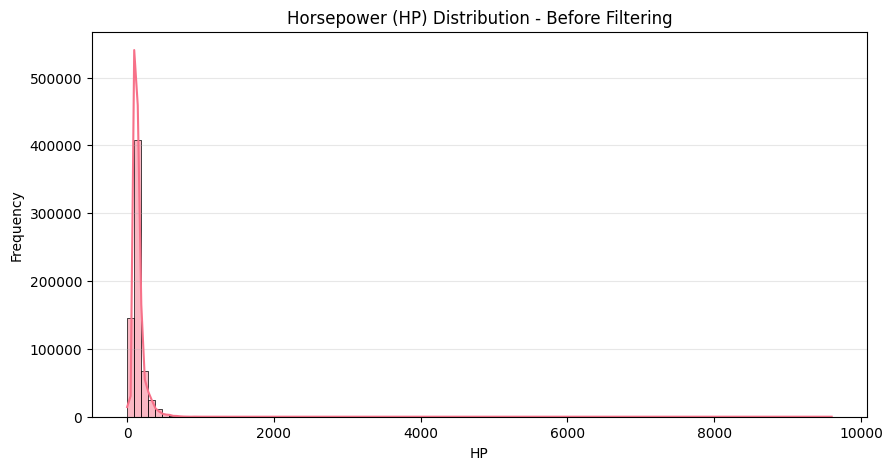


--- Applying Hard Limits (50 <= HP <= 1000) ---
Rows dropped by hard limits: 5,334


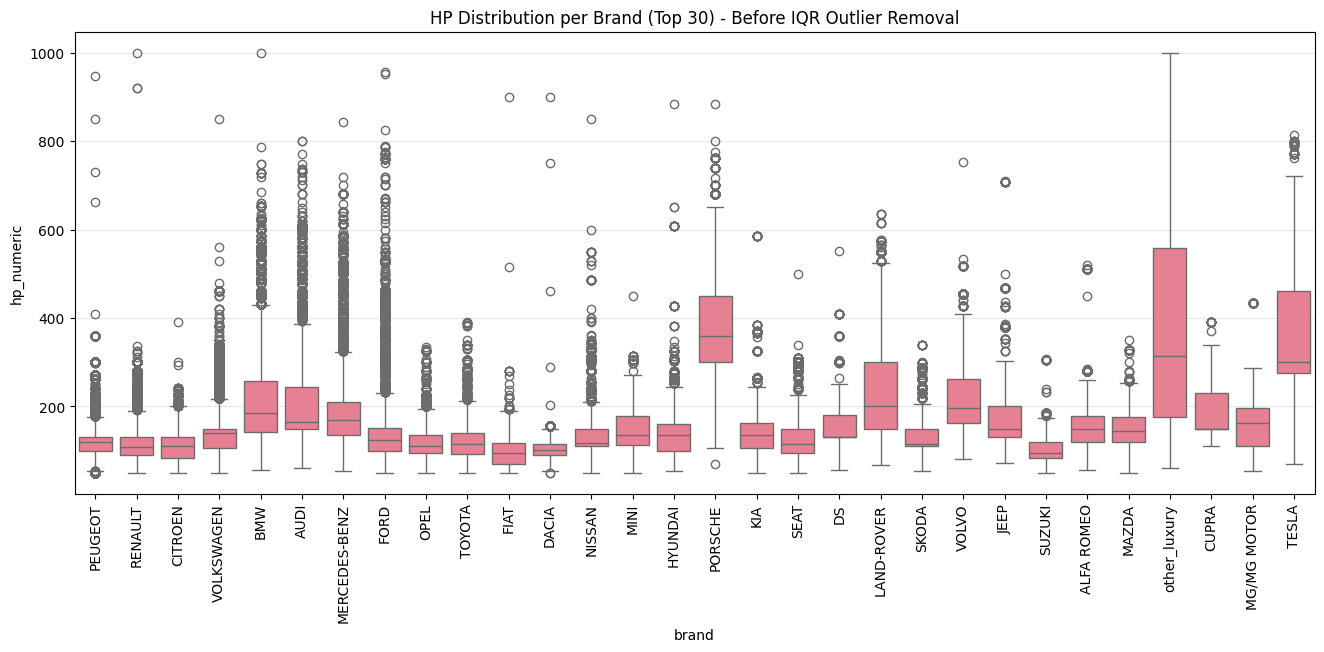


--- Applying IQR Outlier Removal per Brand ---
Rows dropped by IQR: 34,137 (5.0%)

Top 10 Brands by fraction of outliers removed:
shape: (10, 4)
┌───────────────┬────────┬─────────┬──────────────────┐
│ brand         ┆ total  ┆ dropped ┆ fraction_dropped │
│ ---           ┆ ---    ┆ ---     ┆ ---              │
│ str           ┆ u32    ┆ u32     ┆ f64              │
╞═══════════════╪════════╪═════════╪══════════════════╡
│ DODGE         ┆ 949    ┆ 144     ┆ 0.151739         │
│ LEXUS         ┆ 1661   ┆ 190     ┆ 0.114389         │
│ VOLKSWAGEN    ┆ 53503  ┆ 5442    ┆ 0.101714         │
│ MERCEDES-BENZ ┆ 40900  ┆ 3727    ┆ 0.091125         │
│ FORD          ┆ 27068  ┆ 2165    ┆ 0.079984         │
│ PEUGEOT       ┆ 105848 ┆ 7811    ┆ 0.073794         │
│ AUDI          ┆ 42133  ┆ 2704    ┆ 0.064178         │
│ SKODA         ┆ 7015   ┆ 436     ┆ 0.062153         │
│ HONDA         ┆ 2135   ┆ 132     ┆ 0.061827         │
│ CHRYSLER      ┆ 560    ┆ 34      ┆ 0.060714         │
└─────────────

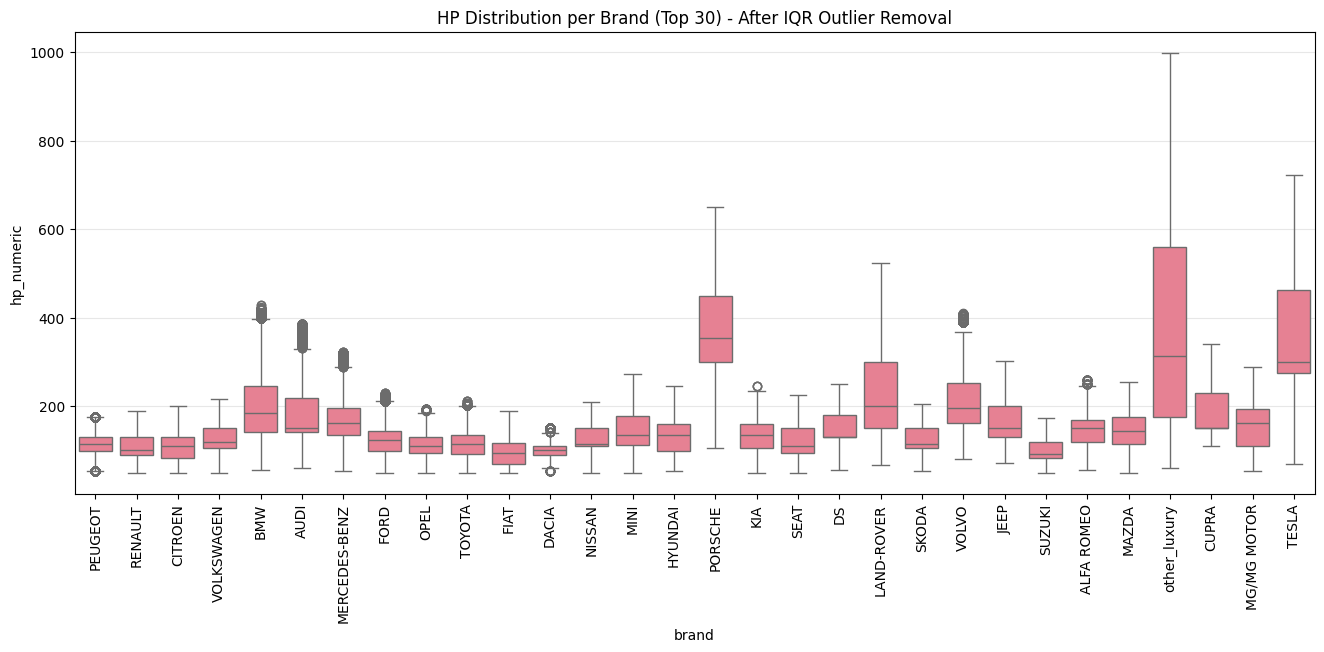


Final HP Statistics:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ hp_numeric │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 623949.0   │
│ null_count ┆ 27695.0    │
│ mean       ┆ 140.574576 │
│ std        ┆ 70.155747  │
│ min        ┆ 50.0       │
│ 25%        ┆ 100.0      │
│ 50%        ┆ 125.0      │
│ 75%        ┆ 150.0      │
│ max        ┆ 1000.0     │
└────────────┴────────────┘


In [3]:
# 1. Analyze puissance_din (Horsepower)
print("--- Horsepower (puissance_din) Analysis ---")

# Convert to numeric first
df = df.with_columns(
    pl.col("puissance_din")
    .str.extract(r"(\d+)", 1)
    .cast(pl.Int32, strict=False)
    .alias("hp_numeric")
)

# 1. Check Missing Values
null_hp = df.filter(pl.col("puissance_din").is_null()).height
total_rows = df.height
print(f"Missing HP values (puissance_din): {null_hp:,} ({null_hp/total_rows:.1%})")

# 2. Check suffixes
suffixes = df.filter(pl.col("puissance_din").is_not_null()).select(
    pl.col("puissance_din").str.replace_all(r"[0-9\s]", "").alias("suffix")
).unique()
print("Unique suffixes found:", suffixes["suffix"].to_list())

# 3. Visualize Distribution Before Filtering
plt.figure(figsize=(10, 5))
# Filtering out extremely large values for visualization purposes only if they exist, 
# but showing the raw distribution as requested.
sns.histplot(df["hp_numeric"].drop_nulls(), bins=100, kde=True)
plt.title("Horsepower (HP) Distribution - Before Filtering")
plt.xlabel("HP")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 4. Hard Limits Filter (< 50 or > 1000)
print("\n--- Applying Hard Limits (50 <= HP <= 1000) ---")
rows_start = df.height
df = df.filter(
    pl.col("hp_numeric").is_null() | 
    ((pl.col("hp_numeric") >= 50) & (pl.col("hp_numeric") <= 1000))
)
print(f"Rows dropped by hard limits: {rows_start - df.height:,}")

# Prepare for visualization (Top 30 brands)
top_30_brands = df.group_by("brand").len().sort("len", descending=True).head(30)["brand"].to_list()
df_top30_before = df.filter(pl.col("brand").is_in(top_30_brands))

# Visualize Before IQR
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_top30_before.to_pandas(), x="brand", y="hp_numeric", order=top_30_brands)
plt.xticks(rotation=90)
plt.title("HP Distribution per Brand (Top 30) - Before IQR Outlier Removal")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 5. IQR Outlier Removal per Brand
print("\n--- Applying IQR Outlier Removal per Brand ---")
rows_before_iqr = df.height

# Calculate bounds per brand
hp_bounds = df.filter(pl.col("hp_numeric").is_not_null()).group_by("brand").agg([
    pl.col("hp_numeric").quantile(0.25).alias("q1_hp"),
    pl.col("hp_numeric").quantile(0.75).alias("q3_hp")
]).with_columns([
    (pl.col("q3_hp") - pl.col("q1_hp")).alias("iqr_hp")
]).with_columns([
    (pl.col("q1_hp") - 1.5 * pl.col("iqr_hp")).alias("lower_bound_hp"),
    (pl.col("q3_hp") + 1.5 * pl.col("iqr_hp")).alias("upper_bound_hp")
])

# Join bounds
df_with_bounds = df.join(hp_bounds, on="brand", how="left")

# Identify outliers
outliers = df_with_bounds.filter(
    pl.col("hp_numeric").is_not_null() & 
    (
        (pl.col("hp_numeric") < pl.col("lower_bound_hp")) | 
        (pl.col("hp_numeric") > pl.col("upper_bound_hp"))
    )
)

dropped_count = outliers.height
print(f"Rows dropped by IQR: {dropped_count:,} ({dropped_count/rows_before_iqr:.1%})")

# Calculate fraction dropped per brand
brand_stats = df.group_by("brand").len().rename({"len": "total"})
outlier_stats = outliers.group_by("brand").len().rename({"len": "dropped"})
brand_outlier_stats = brand_stats.join(outlier_stats, on="brand", how="left").fill_null(0)
brand_outlier_stats = brand_outlier_stats.with_columns(
    (pl.col("dropped") / pl.col("total")).alias("fraction_dropped")
).sort("fraction_dropped", descending=True)

print("\nTop 10 Brands by fraction of outliers removed:")
print(brand_outlier_stats.head(10))

# Apply filtering
df = df_with_bounds.filter(
    pl.col("hp_numeric").is_null() | 
    (
        (pl.col("hp_numeric") >= pl.col("lower_bound_hp")) & 
        (pl.col("hp_numeric") <= pl.col("upper_bound_hp"))
    )
).drop(["q1_hp", "q3_hp", "iqr_hp", "lower_bound_hp", "upper_bound_hp"])

# Visualize After IQR
df_top30_after = df.filter(pl.col("brand").is_in(top_30_brands))

plt.figure(figsize=(16, 6))
sns.boxplot(data=df_top30_after.to_pandas(), x="brand", y="hp_numeric", order=top_30_brands)
plt.xticks(rotation=90)
plt.title("HP Distribution per Brand (Top 30) - After IQR Outlier Removal")
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\nFinal HP Statistics:")
print(df.select("hp_numeric").describe())

In [11]:
# 2. Analyze energie (Energy Source)
print("\n--- Energy Source (energie) Analysis ---")
print("Value Counts:")
print(df["energie"].value_counts(sort=True))

# Check for missing
missing_energy = df.filter(pl.col("energie").is_null()).height
total_rows = df.height
print(f"\nMissing Energy values: {missing_energy:,} ({missing_energy/total_rows:.1%})")


--- Energy Source (energie) Analysis ---
Value Counts:
shape: (9, 2)
┌──────────────────────┬────────┐
│ energie              ┆ count  │
│ ---                  ┆ ---    │
│ str                  ┆ u32    │
╞══════════════════════╪════════╡
│ Diesel               ┆ 269878 │
│ Essence              ┆ 264212 │
│ Hybride              ┆ 68515  │
│ Électrique           ┆ 36361  │
│ Hybride Rechargeable ┆ 6097   │
│ GPL                  ┆ 4768   │
│ Gaz Naturel (GNV)    ┆ 926    │
│ Autre                ┆ 848    │
│ Hydrogène            ┆ 39     │
└──────────────────────┴────────┘

Missing Energy values: 0 (0.0%)


### SECTION 3 – New Quantile/Rank-Based Brand and Model Features

**Idea:** Instead of just raw average price, we want to know where a brand/model sits in the global market hierarchy (e.g., is it a "Top 5%" luxury brand?). We also want to know the rank of a model *within* its brand (entry-level vs. flagship).

**New Features:**
- `brand_top25_price`, `brand_bottom25_price`, `brand_top5_price`
- `model_top25_price`, `model_bottom25_price`, `model_top5_price`
- `model_rank_within_brand`

In [12]:
# 1. Brand-level Quantiles (Using Median for robustness)
brand_stats = df.group_by("brand").agg(
    pl.col("price").median().alias("brand_median_price_temp")
)

# Calculate global quantiles for brand medians
q25_brand = brand_stats["brand_median_price_temp"].quantile(0.25)
q75_brand = brand_stats["brand_median_price_temp"].quantile(0.75)
q95_brand = brand_stats["brand_median_price_temp"].quantile(0.95)

brand_features = brand_stats.with_columns([
    (pl.col("brand_median_price_temp") >= q75_brand).cast(pl.Int8).alias("brand_top25_price"),
    (pl.col("brand_median_price_temp") <= q25_brand).cast(pl.Int8).alias("brand_bottom25_price"),
    (pl.col("brand_median_price_temp") >= q95_brand).cast(pl.Int8).alias("brand_top5_price")
]).drop("brand_median_price_temp")

# 2. Model-level Quantiles (Using Median)
model_stats = df.group_by("model").agg(
    pl.col("price").median().alias("model_median_price_temp")
)

q25_model = model_stats["model_median_price_temp"].quantile(0.25)
q75_model = model_stats["model_median_price_temp"].quantile(0.75)
q95_model = model_stats["model_median_price_temp"].quantile(0.95)

model_features = model_stats.with_columns([
    (pl.col("model_median_price_temp") >= q75_model).cast(pl.Int8).alias("model_top25_price"),
    (pl.col("model_median_price_temp") <= q25_model).cast(pl.Int8).alias("model_bottom25_price"),
    (pl.col("model_median_price_temp") >= q95_model).cast(pl.Int8).alias("model_top5_price")
]).drop("model_median_price_temp")

# 3. Model Rank within Brand (Based on Median Price)
# We need brand and model for this
model_brand_stats = df.group_by(["brand", "model"]).agg(
    pl.col("price").median().alias("model_median_price_rank_base")
)

model_rank_features = model_brand_stats.with_columns(
    pl.col("model_median_price_rank_base")
    .rank("dense", descending=False)
    .over("brand")
    .alias("model_rank_within_brand")
).drop("model_median_price_rank_base")

# Join all back
df = df.join(brand_features, on="brand", how="left")
df = df.join(model_features, on="model", how="left")
df = df.join(model_rank_features, on=["brand", "model"], how="left")

# Sanity Check
print("Brand Top 5% examples (Median-based):")
print(df.filter(pl.col("brand_top5_price") == 1).select("brand").unique().head(5))

print("\nModel Rank examples (Brand with multiple models):")
sample_brand = df.filter(pl.col("model_rank_within_brand") > 3).select("brand").head(1).item()
print(f"Brand: {sample_brand}")
print(df.filter(pl.col("brand") == sample_brand)
      .group_by(["model", "model_rank_within_brand"])
      .agg(pl.col("price").median().alias("median_price"))
      .sort("model_rank_within_brand"))

Brand Top 5% examples (Median-based):
shape: (3, 1)
┌─────────┐
│ brand   │
│ ---     │
│ str     │
╞═════════╡
│ FERRARI │
│ ALPINE  │
│ PORSCHE │
└─────────┘

Model Rank examples (Brand with multiple models):
Brand: DACIA
shape: (9, 3)
┌───────────────┬─────────────────────────┬──────────────┐
│ model         ┆ model_rank_within_brand ┆ median_price │
│ ---           ┆ ---                     ┆ ---          │
│ str           ┆ u32                     ┆ f64          │
╞═══════════════╪═════════════════════════╪══════════════╡
│ Logan Pick-Up ┆ 1                       ┆ 6500.0       │
│ Logan         ┆ 2                       ┆ 6900.0       │
│ Lodgy         ┆ 3                       ┆ 8990.0       │
│ Dokker        ┆ 4                       ┆ 9999.5       │
│ Spring        ┆ 5                       ┆ 10995.0      │
│ Sandero       ┆ 6                       ┆ 12500.0      │
│ Duster        ┆ 7                       ┆ 17000.0      │
│ Jogger        ┆ 8                       ┆ 19900.0   

### SECTION 4 – Volume / Rarity Features

**Idea:** Rare models might have different pricing dynamics (collectible or unwanted) compared to common ones. Market share indicates popularity.

**New Features:**
- `brand_market_share`, `model_market_share`
- `is_rare_model`, `is_common_model`

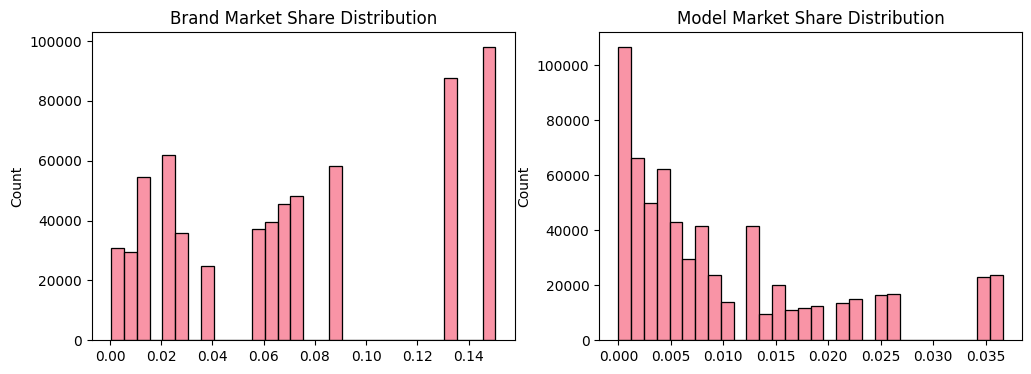

Rare models example:
shape: (5, 3)
┌───────────────┬────────────┬─────────────┐
│ brand         ┆ model      ┆ model_count │
│ ---           ┆ ---        ┆ ---         │
│ str           ┆ str        ┆ u32         │
╞═══════════════╪════════════╪═════════════╡
│ HYUNDAI       ┆ H-1 Starex ┆ 3           │
│ MERCEDES-BENZ ┆ Classe T   ┆ 30          │
│ MERCEDES-BENZ ┆ EQE SUV    ┆ 4           │
│ AIXAM         ┆ Roadline   ┆ 4           │
│ FERRARI       ┆ F8 Tributo ┆ 16          │
└───────────────┴────────────┴─────────────┘


In [13]:
total_cars = df.height

# add brand and model counts
df = df.join(df.group_by("brand").agg(pl.len().alias("brand_count")), on="brand", how="left")
df = df.join(df.group_by("model").agg(pl.len().alias("model_count")), on="model", how="left")

df = df.with_columns([
    (pl.col("brand_count") / total_cars).alias("brand_market_share"),
    (pl.col("model_count") / total_cars).alias("model_market_share"),
    (pl.col("model_count") < 50).cast(pl.Int8).alias("is_rare_model"),
    (pl.col("model_count") > 2000).cast(pl.Int8).alias("is_common_model")
])

# Show distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df["brand_market_share"], bins=30)
plt.title("Brand Market Share Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df["model_market_share"], bins=30)
plt.title("Model Market Share Distribution")
plt.show()

print("Rare models example:")
print(df.filter(pl.col("is_rare_model") == 1).select(["brand", "model", "model_count"]).unique().head())

### SECTION 5 – Advanced Age / Mileage / HP Features

**Idea:** Non-linear effects of age and mileage. Also, relative performance (HP) within a brand.

**New Features:**
- `age_squared`, `mileage_squared`
- `km_per_year` (if not present)
- `is_high_hp_within_brand`, `is_low_hp_within_brand`
- `is_new_car`, `is_old_car`

In [14]:
CURRENT_YEAR = 2025

# 1. Age and Mileage Features

df = df.with_columns((CURRENT_YEAR - pl.col("year")).alias("car_age"))

df = df.with_columns([
    (pl.col("car_age") ** 2).alias("age_squared"),
    (pl.col("km") ** 2).alias("mileage_squared"),
    (pl.col("km") / (pl.col("car_age") + 1)).alias("km_per_year"),
    (pl.col("car_age") < 2).cast(pl.Int8).alias("is_new_car"),
    (pl.col("car_age") > 15).cast(pl.Int8).alias("is_old_car")
])

# 2. HP Relative Features (Performance within brand)
if "hp_numeric" in df.columns:
    # Calculate quantiles per brand for performance categorization
    hp_stats = df.group_by("brand").agg([
        pl.col("hp_numeric").quantile(0.25).alias("hp_p25"),
        pl.col("hp_numeric").quantile(0.90).alias("hp_p90")
    ])
    
    df = df.join(hp_stats, on="brand", how="left")
    
    df = df.with_columns([
        (pl.col("hp_numeric") > pl.col("hp_p90")).cast(pl.Int8).alias("is_high_hp_within_brand"),
        (pl.col("hp_numeric") < pl.col("hp_p25")).cast(pl.Int8).alias("is_low_hp_within_brand")
    ]).drop(["hp_p25", "hp_p90"])
    
    print("Features created: age_squared, mileage_squared, km_per_year, is_new_car, is_old_car, is_high_hp_within_brand, is_low_hp_within_brand")
    
    # Check sample of brand performance features
    print("\nSample of HP-based features:")
    print(df.select(["brand", "hp_numeric", "is_high_hp_within_brand", "is_low_hp_within_brand"]).head(5))
else:
    print("Error: hp_numeric not found in DataFrame. Please ensure Section 2 was executed.")

Features created: age_squared, mileage_squared, km_per_year, is_new_car, is_old_car, is_high_hp_within_brand, is_low_hp_within_brand

Sample of HP-based features:
shape: (5, 4)
┌──────────────┬────────────┬─────────────────────────┬────────────────────────┐
│ brand        ┆ hp_numeric ┆ is_high_hp_within_brand ┆ is_low_hp_within_brand │
│ ---          ┆ ---        ┆ ---                     ┆ ---                    │
│ str          ┆ i32        ┆ i8                      ┆ i8                     │
╞══════════════╪════════════╪═════════════════════════╪════════════════════════╡
│ other_luxury ┆ 320        ┆ 0                       ┆ 0                      │
│ other_luxury ┆ 170        ┆ 0                       ┆ 1                      │
│ other_luxury ┆ 836        ┆ 1                       ┆ 0                      │
│ other_luxury ┆ 285        ┆ 0                       ┆ 0                      │
│ other_luxury ┆ 999        ┆ 1                       ┆ 0                      │
└────────────

### SECTION 5B – Energy Source One-Hot Encoding

Since we want energie as one-hot encoded features instead of string values:
- `is_ev`, `is_hybrid`, `is_alternative_fuel`, `is_traditional_fuel`
- Plus premium variants

In [15]:
# Create one-hot encoded energy features
# Define energy type keywords
ev_terms = ["électrique", "electric"]
hybrid_terms = ["hybride", "hybrid"]
alt_terms = ["gpl", "e85", "éthanol", "gaz"]
trad_terms = ["essence", "diesel", "gasoil"]

# Clean energie column first
df = df.with_columns(
    pl.col("energie").str.to_lowercase().alias("energie_clean")
)

# Create binary energy flags
df = df.with_columns([
    pl.col("energie_clean").str.contains("|".join(ev_terms)).fill_null(False).cast(pl.Int8).alias("is_ev"),
    pl.col("energie_clean").str.contains("|".join(hybrid_terms)).fill_null(False).cast(pl.Int8).alias("is_hybrid"),
    pl.col("energie_clean").str.contains("|".join(alt_terms)).fill_null(False).cast(pl.Int8).alias("is_alternative_fuel"),
    (pl.col("energie_clean").str.contains("|".join(trad_terms)).fill_null(False) & 
     ~pl.col("energie_clean").str.contains("|".join(hybrid_terms)).fill_null(False)).cast(pl.Int8).alias("is_traditional_fuel")
])

# Create premium variants (combine with brand top 25% pricing)
df = df.with_columns([
    (pl.col("is_ev") & pl.col("brand_top25_price")).cast(pl.Int8).alias("is_ev_premium"),
    (pl.col("is_traditional_fuel") & pl.col("brand_top25_price")).cast(pl.Int8).alias("is_traditional_premium")
])

print("Energy OHE features created:")
print(df.select(["energie", "is_ev", "is_hybrid", "is_alternative_fuel", "is_traditional_fuel"]).head(10))

print("\nEnergy distribution:")
print(f"EV: {df['is_ev'].sum():,}")
print(f"Hybrid: {df['is_hybrid'].sum():,}")
print(f"Alternative Fuel: {df['is_alternative_fuel'].sum():,}")
print(f"Traditional Fuel: {df['is_traditional_fuel'].sum():,}")

Energy OHE features created:
shape: (10, 5)
┌────────────┬───────┬───────────┬─────────────────────┬─────────────────────┐
│ energie    ┆ is_ev ┆ is_hybrid ┆ is_alternative_fuel ┆ is_traditional_fuel │
│ ---        ┆ ---   ┆ ---       ┆ ---                 ┆ ---                 │
│ str        ┆ i8    ┆ i8        ┆ i8                  ┆ i8                  │
╞════════════╪═══════╪═══════════╪═════════════════════╪═════════════════════╡
│ Autre      ┆ 0     ┆ 0         ┆ 0                   ┆ 0                   │
│ Électrique ┆ 1     ┆ 0         ┆ 0                   ┆ 0                   │
│ Électrique ┆ 1     ┆ 0         ┆ 0                   ┆ 0                   │
│ Essence    ┆ 0     ┆ 0         ┆ 0                   ┆ 1                   │
│ Électrique ┆ 1     ┆ 0         ┆ 0                   ┆ 0                   │
│ Électrique ┆ 1     ┆ 0         ┆ 0                   ┆ 0                   │
│ Électrique ┆ 1     ┆ 0         ┆ 0                   ┆ 0                   │
│ Diesel

### SECTION 5C – Train/Test Split

Split data into training and test sets (80/20) **before** creating any aggregate features to prevent data leakage.

In [16]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Create train/test split (80/20)
print("Creating train/test split...")

# Convert to pandas for sklearn splitting
df_pandas = df.to_pandas()

# Split indices
train_idx, test_idx = train_test_split(
    df_pandas.index, 
    test_size=0.2, 
    random_state=42
)

df_train = pl.from_pandas(df_pandas.iloc[train_idx].reset_index(drop=True))
df_test = pl.from_pandas(df_pandas.iloc[test_idx].reset_index(drop=True))

print(f"Train set size: {df_train.height:,}")
print(f"Test set size: {df_test.height:,}")

# Extract target variable
y_train = df_train["price"].to_numpy()
y_test = df_test["price"].to_numpy()

print(f"\nTarget statistics:")
print(f"  Train - Min: €{y_train.min():,.0f}, Max: €{y_train.max():,.0f}, Median: €{np.median(y_train):,.0f}")
print(f"  Test  - Min: €{y_test.min():,.0f}, Max: €{y_test.max():,.0f}, Median: €{np.median(y_test):,.0f}")

Creating train/test split...
Train set size: 521,315
Test set size: 130,329

Target statistics:
  Train - Min: €200, Max: €750,000, Median: €14,000
  Test  - Min: €200, Max: €749,990, Median: €14,191


### SECTION 5D – Advanced Feature Engineering with Leakage Prevention

Create additional aggregate features (brand/model CV, etc.) **fit on training data only** to prevent leakage.

In [18]:
# ============================================================================
# Feature Engineering Class to Prevent Data Leakage
# ============================================================================
class AdvancedFeatureEngineer:
    """
    Feature engineering class that computes aggregate statistics on training data
    and applies them to both train and test sets to prevent data leakage.
    
    Creates brand_price_cv and model_price_cv features.
    """
    
    def __init__(self):
        self.brand_stats = None
        self.model_stats = None
        
    def fit(self, df_train):
        """Compute statistics on training data only"""
        
        # Brand-level coefficient of variation (CV) = std / mean
        self.brand_stats = df_train.group_by("brand").agg([
            pl.col("price").mean().alias("brand_mean"),
            pl.col("price").std().alias("brand_std")
        ]).with_columns([
            (pl.col("brand_std") / (pl.col("brand_mean") + 1)).alias("brand_price_cv")
        ]).select(["brand", "brand_price_cv"])
        
        # Model-level coefficient of variation
        self.model_stats = df_train.group_by("model").agg([
            pl.col("price").mean().alias("model_mean"),
            pl.col("price").std().alias("model_std")
        ]).with_columns([
            (pl.col("model_std") / (pl.col("model_mean") + 1)).alias("model_price_cv")
        ]).select(["model", "model_price_cv"])
        
        return self
    
    def transform(self, df):
        """Apply learned statistics to transform the dataframe"""
        
        # Join brand CV
        df_transformed = df.join(
            self.brand_stats,
            on="brand",
            how="left"
        )
        
        # Join model CV
        df_transformed = df_transformed.join(
            self.model_stats,
            on="model",
            how="left"
        )
        
        return df_transformed

# Initialize and fit the feature engineer on training data only
print("=" * 80)
print("FITTING ADVANCED FEATURE ENGINEER ON TRAINING DATA")
print("=" * 80)

feature_engineer = AdvancedFeatureEngineer()
feature_engineer.fit(df_train)

# Transform both train and test
df_train_fe = feature_engineer.transform(df_train)
df_test_fe = feature_engineer.transform(df_test)

print(f"\n✓ Feature engineering completed without data leakage")
print(f"  Training features shape: {df_train_fe.shape}")
print(f"  Test features shape: {df_test_fe.shape}")

# Show new features
print(f"\nNew features created: brand_price_cv, model_price_cv")
print(f"\nSample of new features:")
print(df_train_fe.select(["brand", "brand_price_cv", "model", "model_price_cv"]).head(5))

FITTING ADVANCED FEATURE ENGINEER ON TRAINING DATA

✓ Feature engineering completed without data leakage
  Training features shape: (521315, 47)
  Test features shape: (130329, 47)

New features created: brand_price_cv, model_price_cv

Sample of new features:
shape: (5, 4)
┌───────────────┬────────────────┬────────────┬────────────────┐
│ brand         ┆ brand_price_cv ┆ model      ┆ model_price_cv │
│ ---           ┆ ---            ┆ ---        ┆ ---            │
│ str           ┆ f64            ┆ str        ┆ f64            │
╞═══════════════╪════════════════╪════════════╪════════════════╡
│ TOYOTA        ┆ 0.539123       ┆ Corolla    ┆ 0.289367       │
│ MERCEDES-BENZ ┆ 0.649527       ┆ Classe SLK ┆ 0.45632        │
│ PEUGEOT       ┆ 0.65979        ┆ 208        ┆ 0.452317       │
│ FORD          ┆ 0.731697       ┆ Ranger     ┆ 0.443278       │
│ RENAULT       ┆ 0.683306       ┆ Megane     ┆ 0.638928       │
└───────────────┴────────────────┴────────────┴────────────────┘


### SECTION 6 – Model Comparison: CarPriceFeatureEngineer vs Expanded Features

**Objective:** Compare two LGBM models to evaluate the impact of new features:
1. **Model 1 (Baseline)**: Features from `CarPriceFeatureEngineer` class (same as notebook 04)
2. **Model 2 (Expanded)**: Baseline features + new features from Sections 2-5 + one-hot encoded brand

**Key Changes:**
- Use median (Q50) prediction only
- Log-transform target variable (same as notebook 04)
- Use same LGBM parameters as notebook 04
- Evaluate precision across multiple metrics
- Compare performance across top 30 brands
- Analyze feature importance to identify high-ranking new features

In [20]:
# ============================================================================
# DATA PREPARATION: Remove Data Leakage Features
# ============================================================================
print("=" * 80)
print("PREPARING DATA FOR MODEL COMPARISON")
print("=" * 80)

# Remove features that cause data leakage (they use actual price!)
LEAKAGE_FEATURES = ['price_dev_from_brand_avg', 'price_dev_from_model_avg']

print(f"\n⚠️  Removing {len(LEAKAGE_FEATURES)} features with data leakage:")
for feat in LEAKAGE_FEATURES:
    if feat in df_train_fe.columns:
        print(f"  - {feat}")
        df_train_fe = df_train_fe.drop(feat)
        df_test_fe = df_test_fe.drop(feat)

# Create train/test split
print(f"\nDataset sizes:")
print(f"  Training: {df_train.height:,} rows")
print(f"  Test: {df_test.height:,} rows")

# Extract target variable
y_train = df_train["price"].to_numpy()
y_test = df_test["price"].to_numpy()

print(f"\nTarget statistics:")
print(f"  Train - Min: €{y_train.min():,.0f}, Max: €{y_train.max():,.0f}, Median: €{np.median(y_train):,.0f}")
print(f"  Test  - Min: €{y_test.min():,.0f}, Max: €{y_test.max():,.0f}, Median: €{np.median(y_test):,.0f}")

# Log-transform target (same as notebook 04)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f"\nLog-transformed target range:")
print(f"  Train: {y_train_log.min():.2f} - {y_train_log.max():.2f}")
print(f"  Test:  {y_test_log.min():.2f} - {y_test_log.max():.2f}")

print("\n✓ Data preparation completed")

PREPARING DATA FOR MODEL COMPARISON

⚠️  Removing 2 features with data leakage:

Dataset sizes:
  Training: 521,315 rows
  Test: 130,329 rows

Target statistics:
  Train - Min: €200, Max: €750,000, Median: €14,000
  Test  - Min: €200, Max: €749,990, Median: €14,191

Log-transformed target range:
  Train: 5.30 - 13.53
  Test:  5.30 - 13.53

✓ Data preparation completed


In [21]:
# ============================================================================
# MODEL 1: BASELINE WITH CarPriceFeatureEngineer
# ============================================================================
print("\n" + "=" * 80)
print("MODEL 1: BASELINE FEATURES (CarPriceFeatureEngineer)")
print("=" * 80)

from src.features.feature_engineering import CarPriceFeatureEngineer

# Initialize feature engineer (same config as notebook 04)
fe_baseline = CarPriceFeatureEngineer(
    current_year=2025,
    add_log_features=True,
    add_polynomial_features=True,
    add_target_encoding=True,
    add_categorical_features=False,
    add_interaction_features=True
)

# Fit ONLY on training data (expects Polars DataFrame)
print("\nFitting CarPriceFeatureEngineer on training data...")
fe_baseline.fit(df_train, y_train)

# Transform both sets (returns Polars DataFrames)
X_train_baseline_pl = fe_baseline.transform(df_train)
X_test_baseline_pl = fe_baseline.transform(df_test)

# Define columns to drop
COLS_TO_DROP = ['brand', 'model', 'year', 'price', 'split_id']

# EXCLUDE HP and Energy-related features per user request
HP_ENERGY_COLS = [
    'hp_numeric', 'puissance_din', 'energie', 'energie_clean',
    'is_high_hp_within_brand', 'is_low_hp_within_brand',
    'is_ev', 'is_hybrid', 'is_alternative_fuel', 'is_traditional_fuel',
    'is_ev_premium', 'is_traditional_premium'
]

# Drop all unwanted columns
all_cols_to_drop = list(set(COLS_TO_DROP + HP_ENERGY_COLS))
X_train_baseline = X_train_baseline_pl.drop([c for c in all_cols_to_drop if c in X_train_baseline_pl.columns]).to_pandas()
X_test_baseline = X_test_baseline_pl.drop([c for c in all_cols_to_drop if c in X_test_baseline_pl.columns]).to_pandas()

print(f"\n✓ Baseline features (EXCLUDING HP and Energy): {X_train_baseline.shape[1]}")
print(f"  Dropped HP/Energy columns: {[c for c in HP_ENERGY_COLS if c in X_train_baseline_pl.columns]}")
print("\nFeatures:")
for i, col in enumerate(X_train_baseline.columns, 1):
    print(f"  {i:2d}. {col}")

baseline_features = X_train_baseline.columns.tolist()


MODEL 1: BASELINE FEATURES (CarPriceFeatureEngineer)

Fitting CarPriceFeatureEngineer on training data...

✓ Baseline features (EXCLUDING HP and Energy): 50
  Dropped HP/Energy columns: ['hp_numeric', 'puissance_din', 'energie', 'energie_clean', 'is_high_hp_within_brand', 'is_low_hp_within_brand', 'is_ev', 'is_hybrid', 'is_alternative_fuel', 'is_traditional_fuel', 'is_ev_premium', 'is_traditional_premium']

Features:
   1. km
   2. brand_top25_price
   3. brand_bottom25_price
   4. brand_top5_price
   5. model_top25_price
   6. model_bottom25_price
   7. model_top5_price
   8. model_rank_within_brand
   9. brand_count
  10. model_count
  11. brand_market_share
  12. model_market_share
  13. is_rare_model
  14. is_common_model
  15. car_age
  16. age_squared
  17. mileage_squared
  18. km_per_year
  19. is_new_car
  20. is_old_car
  21. brand_top25_price_right
  22. brand_bottom25_price_right
  23. brand_top5_price_right
  24. model_top25_price_right
  25. model_bottom25_price_right
  

In [33]:
# ============================================================================
# MODEL 2: EXPANDED FEATURES (Baseline + Brands OHE + Energy OHE + CV Features)
# ============================================================================
print("\n" + "=" * 80)
print("MODEL 2: EXPANDED FEATURES")
print("=" * 80)

import re

# Start with baseline features (excludes HP and energie features)
X_train_expanded = X_train_baseline.copy()
X_test_expanded = X_test_baseline.copy()

print(f"\nStarting with baseline: {X_train_expanded.shape[1]} features")

# ============================================================================
# 1. Add Horsepower (hp_numeric)
# ============================================================================
# Add hp_numeric from the original train/test data
print(f"\nAdding horsepower feature:")
if 'hp_numeric' in df_train.columns:
    print(f"  + hp_numeric")
    X_train_expanded['hp_numeric'] = df_train.select('hp_numeric').to_pandas().values
    X_test_expanded['hp_numeric'] = df_test.select('hp_numeric').to_pandas().values

# ============================================================================
# 2. Add Energy One-Hot Encoded Features
# ============================================================================
# These come from Section 5B where we one-hot encode the 'energie' column
energy_features = ['is_ev', 'is_hybrid', 'is_alternative_fuel', 'is_traditional_fuel', 
                   'is_ev_premium', 'is_traditional_premium']

print(f"\nAdding {len(energy_features)} energy OHE features (from Section 5B - energie column):")
for feat in energy_features:
    if feat in df_train_fe.columns:
        print(f"  + {feat}")
        X_train_expanded[feat] = df_train_fe.select(feat).to_pandas().values
        X_test_expanded[feat] = df_test_fe.select(feat).to_pandas().values

# ============================================================================
# 3. Add Brand One-Hot Encoded Features
# ============================================================================
all_brands = df_train["brand"].unique().to_list()
print(f"\nOne-hot encoding {len(all_brands)} brands (no brands dropped)...")

brand_ohe_train = pd.DataFrame()
brand_ohe_test = pd.DataFrame()

for brand in all_brands:
    safe_brand = re.sub(r"[^0-9a-zA-Z_]", "_", str(brand))
    brand_col_name = f"brand_{safe_brand}"
    brand_ohe_train[brand_col_name] = (df_train["brand"] == brand).cast(pl.Int8).to_numpy()
    brand_ohe_test[brand_col_name] = (df_test["brand"] == brand).cast(pl.Int8).to_numpy()

X_train_expanded = pd.concat([X_train_expanded, brand_ohe_train], axis=1)
X_test_expanded = pd.concat([X_test_expanded, brand_ohe_test], axis=1)

# ============================================================================
# 4. Add CV Features (from Section 5D - AdvancedFeatureEngineer class)
# ============================================================================
cv_features = ['brand_price_cv', 'model_price_cv']
print(f"\nAdding {len(cv_features)} CV features (from Section 5D - AdvancedFeatureEngineer):")
for feat in cv_features:
    if feat in df_train_fe.columns:
        print(f"  + {feat}")
        X_train_expanded[feat] = df_train_fe.select(feat).to_pandas().values
        X_test_expanded[feat] = df_test_fe.select(feat).to_pandas().values

# ============================================================================
# Summary
# ============================================================================
print(f"\n" + "=" * 80)
print(f"EXPANDED FEATURES SUMMARY")
print(f"=" * 80)
print(f"  Baseline features (no HP/energy):  {X_train_baseline.shape[1]}")
print(f"  + Horsepower (hp_numeric):          1")
print(f"  + Energy OHE features:              {len([f for f in energy_features if f in df_train_fe.columns])}")
print(f"  + Brand OHE features:               {len(all_brands)}")
print(f"  + CV features (brand/model):        {len([f for f in cv_features if f in df_train_fe.columns])}")
print(f"  = Total:                            {X_train_expanded.shape[1]}")

expanded_features = X_train_expanded.columns.tolist()


MODEL 2: EXPANDED FEATURES

Starting with baseline: 50 features

Adding horsepower feature:
  + hp_numeric

Adding 6 energy OHE features (from Section 5B - energie column):
  + is_ev
  + is_hybrid
  + is_alternative_fuel
  + is_traditional_fuel
  + is_ev_premium
  + is_traditional_premium

One-hot encoding 46 brands (no brands dropped)...

Adding 2 CV features (from Section 5D - AdvancedFeatureEngineer):
  + brand_price_cv
  + model_price_cv

EXPANDED FEATURES SUMMARY
  Baseline features (no HP/energy):  50
  + Horsepower (hp_numeric):          1
  + Energy OHE features:              6
  + Brand OHE features:               46
  + CV features (brand/model):        2
  = Total:                            105


In [34]:
# ============================================================================
# TRAIN LGBM MODELS (Same parameters as notebook 04)
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING LGBM MODELS")
print("=" * 80)

# Drop string/object columns that LGBM can't handle
object_cols = X_train_baseline.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    print(f"\n⚠️  Dropping {len(object_cols)} object columns: {object_cols}")
    X_train_baseline = X_train_baseline.drop(columns=object_cols)
    X_test_baseline = X_test_baseline.drop(columns=object_cols)
    X_train_expanded = X_train_expanded.drop(columns=[c for c in object_cols if c in X_train_expanded.columns])
    X_test_expanded = X_test_expanded.drop(columns=[c for c in object_cols if c in X_test_expanded.columns])
    
    # Update feature lists
    baseline_features = X_train_baseline.columns.tolist()
    expanded_features = X_train_expanded.columns.tolist()

print(f"\nFinal feature counts:")
print(f"  Baseline: {X_train_baseline.shape[1]} features")
print(f"  Expanded: {X_train_expanded.shape[1]} features")

# LGBM parameters from notebook 04
lgbm_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 8,
    'num_leaves': 31,
    'random_state': 42,
    'verbose': -1,
    'objective': 'quantile',  # For median prediction
    'alpha': 0.5  # Q50 = Median
}

# ============================================================================
# Model 1: Baseline Features
# ============================================================================
print("\n1. Training LGBM with Baseline Features...")
model_baseline = lgb.LGBMRegressor(**lgbm_params)
model_baseline.fit(X_train_baseline, y_train_log)

# Predict and convert back from log
y_pred_baseline_log = model_baseline.predict(X_test_baseline)
y_pred_baseline = np.expm1(y_pred_baseline_log)

print(f"   ✓ Baseline model trained ({X_train_baseline.shape[1]} features)")

# ============================================================================
# Model 2: Expanded Features
# ============================================================================
print("\n2. Training LGBM with Expanded Features...")
model_expanded = lgb.LGBMRegressor(**lgbm_params)
model_expanded.fit(X_train_expanded, y_train_log)

# Predict and convert back from log
y_pred_expanded_log = model_expanded.predict(X_test_expanded)
y_pred_expanded = np.expm1(y_pred_expanded_log)

print(f"   ✓ Expanded model trained ({X_train_expanded.shape[1]} features)")

print("\n✓ All models trained successfully")


TRAINING LGBM MODELS

Final feature counts:
  Baseline: 50 features
  Expanded: 105 features

1. Training LGBM with Baseline Features...
   ✓ Baseline model trained (50 features)

2. Training LGBM with Expanded Features...
   ✓ Expanded model trained (105 features)

✓ All models trained successfully


## Section 9B: Quantile Regression for Confidence Intervals

Train quantile regression models at Q15 and Q85 to create confidence intervals around the median predictions (Q50). This will help us:
- Understand prediction uncertainty
- Compare confidence interval widths between models
- Identify cases where predictions violate monotonicity (Q15 < Q50 < Q85)

In [35]:
# ============================================================================
# TRAIN QUANTILE REGRESSION MODELS (Q15 and Q85)
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING QUANTILE REGRESSION MODELS FOR CONFIDENCE INTERVALS")
print("=" * 80)

# ============================================================================
# BASELINE MODEL: Q15, Q50 (median), Q85
# ============================================================================
print("\n" + "-" * 80)
print("BASELINE MODEL - Quantile Regressors")
print("-" * 80)

# Q15 (Lower bound)
print("\nTraining Q15 (15th percentile)...")
lgbm_baseline_lower = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    random_state=42,
    verbose=-1,
    objective='quantile',
    alpha=0.15
)
lgbm_baseline_lower.fit(X_train_baseline, y_train_log)
y_pred_baseline_q15_log = lgbm_baseline_lower.predict(X_test_baseline)
y_pred_baseline_q15 = np.expm1(y_pred_baseline_q15_log)
print(f"   ✓ Q15 model trained")

# Q50 (Median) - already trained
y_pred_baseline_q50 = y_pred_baseline
print(f"   ✓ Q50 (median) model already trained")

# Q85 (Upper bound)
print("\nTraining Q85 (85th percentile)...")
lgbm_baseline_upper = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    random_state=42,
    verbose=-1,
    objective='quantile',
    alpha=0.85
)
lgbm_baseline_upper.fit(X_train_baseline, y_train_log)
y_pred_baseline_q85_log = lgbm_baseline_upper.predict(X_test_baseline)
y_pred_baseline_q85 = np.expm1(y_pred_baseline_q85_log)
print(f"   ✓ Q85 model trained")

# ============================================================================
# EXPANDED MODEL: Q15, Q50 (median), Q85
# ============================================================================
print("\n" + "-" * 80)
print("EXPANDED MODEL - Quantile Regressors")
print("-" * 80)

# Q15 (Lower bound)
print("\nTraining Q15 (15th percentile)...")
lgbm_expanded_lower = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    random_state=42,
    verbose=-1,
    objective='quantile',
    alpha=0.15
)
lgbm_expanded_lower.fit(X_train_expanded, y_train_log)
y_pred_expanded_q15_log = lgbm_expanded_lower.predict(X_test_expanded)
y_pred_expanded_q15 = np.expm1(y_pred_expanded_q15_log)
print(f"   ✓ Q15 model trained")

# Q50 (Median) - already trained
y_pred_expanded_q50 = y_pred_expanded
print(f"   ✓ Q50 (median) model already trained")

# Q85 (Upper bound)
print("\nTraining Q85 (85th percentile)...")
lgbm_expanded_upper = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    random_state=42,
    verbose=-1,
    objective='quantile',
    alpha=0.85
)
lgbm_expanded_upper.fit(X_train_expanded, y_train_log)
y_pred_expanded_q85_log = lgbm_expanded_upper.predict(X_test_expanded)
y_pred_expanded_q85 = np.expm1(y_pred_expanded_q85_log)
print(f"   ✓ Q85 model trained")

print("\n" + "=" * 80)
print("✓ All quantile regression models trained successfully")
print("=" * 80)


TRAINING QUANTILE REGRESSION MODELS FOR CONFIDENCE INTERVALS

--------------------------------------------------------------------------------
BASELINE MODEL - Quantile Regressors
--------------------------------------------------------------------------------

Training Q15 (15th percentile)...
   ✓ Q15 model trained
   ✓ Q50 (median) model already trained

Training Q85 (85th percentile)...
   ✓ Q85 model trained

--------------------------------------------------------------------------------
EXPANDED MODEL - Quantile Regressors
--------------------------------------------------------------------------------

Training Q15 (15th percentile)...
   ✓ Q15 model trained
   ✓ Q50 (median) model already trained

Training Q85 (85th percentile)...
   ✓ Q85 model trained

✓ All quantile regression models trained successfully


In [36]:
# ============================================================================
# CONFIDENCE INTERVAL ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("CONFIDENCE INTERVAL ANALYSIS")
print("=" * 80)

# Calculate CI widths
ci_width_baseline = y_pred_baseline_q85 - y_pred_baseline_q15
ci_width_expanded = y_pred_expanded_q85 - y_pred_expanded_q15

# Check for monotonicity violations (Q15 < Q50 < Q85)
violations_baseline = ((y_pred_baseline_q15 > y_pred_baseline_q50) | 
                       (y_pred_baseline_q50 > y_pred_baseline_q85))
violations_expanded = ((y_pred_expanded_q15 > y_pred_expanded_q50) | 
                       (y_pred_expanded_q50 > y_pred_expanded_q85))

print("\n" + "-" * 80)
print("BASELINE MODEL - CI Statistics")
print("-" * 80)
print(f"Average CI Width:    €{ci_width_baseline.mean():,.0f}")
print(f"Median CI Width:     €{np.median(ci_width_baseline):,.0f}")
print(f"Std Dev CI Width:    €{ci_width_baseline.std():,.0f}")
print(f"Min CI Width:        €{ci_width_baseline.min():,.0f}")
print(f"Max CI Width:        €{ci_width_baseline.max():,.0f}")
print(f"\nMonotonicity Violations: {violations_baseline.sum():,} ({100*violations_baseline.sum()/len(violations_baseline):.3f}%)")

print("\n" + "-" * 80)
print("EXPANDED MODEL - CI Statistics")
print("-" * 80)
print(f"Average CI Width:    €{ci_width_expanded.mean():,.0f}")
print(f"Median CI Width:     €{np.median(ci_width_expanded):,.0f}")
print(f"Std Dev CI Width:    €{ci_width_expanded.std():,.0f}")
print(f"Min CI Width:        €{ci_width_expanded.min():,.0f}")
print(f"Max CI Width:        €{ci_width_expanded.max():,.0f}")
print(f"\nMonotonicity Violations: {violations_expanded.sum():,} ({100*violations_expanded.sum()/len(violations_expanded):.3f}%)")

# Comparison
print("\n" + "=" * 80)
print("CONFIDENCE INTERVAL COMPARISON")
print("=" * 80)
narrower_expanded = (ci_width_expanded < ci_width_baseline).sum()
wider_expanded = (ci_width_expanded > ci_width_baseline).sum()
same_width = (ci_width_expanded == ci_width_baseline).sum()

print(f"\nExpanded model has narrower CI:  {narrower_expanded:,} predictions ({100*narrower_expanded/len(ci_width_baseline):.2f}%)")
print(f"Expanded model has wider CI:     {wider_expanded:,} predictions ({100*wider_expanded/len(ci_width_baseline):.2f}%)")
print(f"Same width:                      {same_width:,} predictions ({100*same_width/len(ci_width_baseline):.2f}%)")

avg_width_reduction = ci_width_baseline.mean() - ci_width_expanded.mean()
pct_width_reduction = 100 * avg_width_reduction / ci_width_baseline.mean()

print(f"\nAverage CI width reduction:      €{avg_width_reduction:,.0f} ({pct_width_reduction:.2f}%)")

# Relative CI width (as % of prediction)
rel_width_baseline = 100 * ci_width_baseline / y_pred_baseline_q50
rel_width_expanded = 100 * ci_width_expanded / y_pred_expanded_q50

print(f"\nRelative CI Width (% of prediction):")
print(f"  Baseline:  {rel_width_baseline.mean():.2f}% (median: {np.median(rel_width_baseline):.2f}%)")
print(f"  Expanded:  {rel_width_expanded.mean():.2f}% (median: {np.median(rel_width_expanded):.2f}%)")

print("\n" + "=" * 80)
print("✓ Confidence interval analysis completed")
print("=" * 80)


CONFIDENCE INTERVAL ANALYSIS

--------------------------------------------------------------------------------
BASELINE MODEL - CI Statistics
--------------------------------------------------------------------------------
Average CI Width:    €6,431
Median CI Width:     €4,430
Std Dev CI Width:    €10,975
Min CI Width:        €-2,493
Max CI Width:        €291,630

Monotonicity Violations: 211 (0.162%)

--------------------------------------------------------------------------------
EXPANDED MODEL - CI Statistics
--------------------------------------------------------------------------------
Average CI Width:    €5,122
Median CI Width:     €3,624
Std Dev CI Width:    €7,373
Min CI Width:        €-4,447
Max CI Width:        €437,061

Monotonicity Violations: 394 (0.302%)

CONFIDENCE INTERVAL COMPARISON

Expanded model has narrower CI:  98,511 predictions (75.59%)
Expanded model has wider CI:     31,818 predictions (24.41%)
Same width:                      0 predictions (0.00%)

Averag


GENERATING CONFIDENCE INTERVAL VISUALIZATIONS


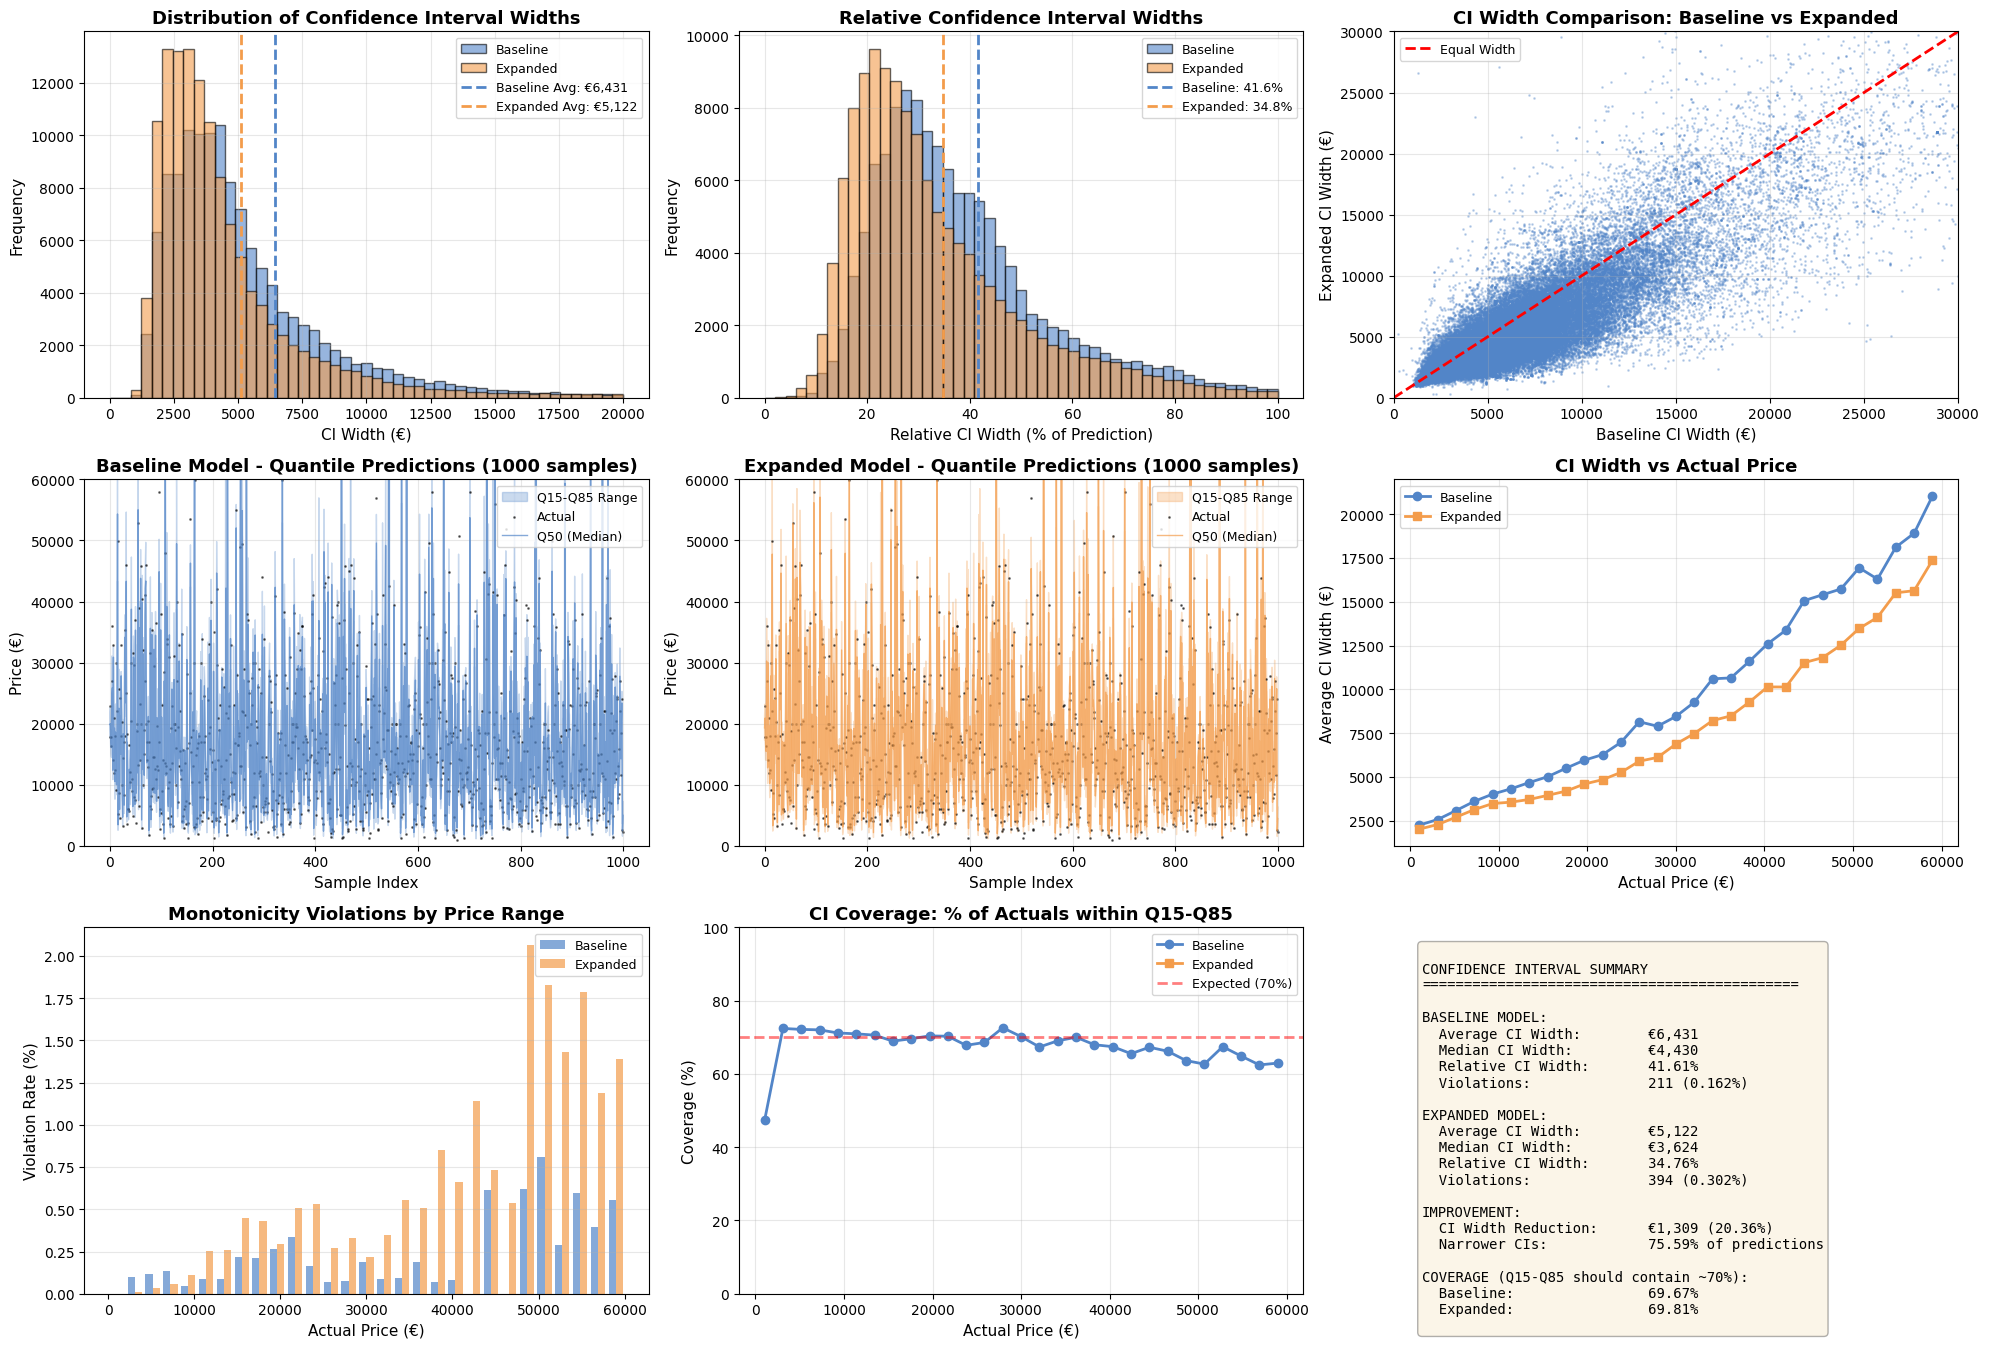


✓ Confidence interval visualizations generated


In [37]:
# ============================================================================
# CONFIDENCE INTERVAL VISUALIZATIONS
# ============================================================================
print("\n" + "=" * 80)
print("GENERATING CONFIDENCE INTERVAL VISUALIZATIONS")
print("=" * 80)

fig = plt.figure(figsize=(20, 14))

# ============================================================================
# 1. CI Width Distribution Comparison
# ============================================================================
ax1 = plt.subplot(3, 3, 1)
bins = np.linspace(0, 20000, 50)
ax1.hist(ci_width_baseline, bins=bins, alpha=0.6, label='Baseline', color='#5285C8', edgecolor='black')
ax1.hist(ci_width_expanded, bins=bins, alpha=0.6, label='Expanded', color='#F39C4B', edgecolor='black')
ax1.axvline(ci_width_baseline.mean(), color='#5285C8', linestyle='--', linewidth=2, label=f'Baseline Avg: €{ci_width_baseline.mean():,.0f}')
ax1.axvline(ci_width_expanded.mean(), color='#F39C4B', linestyle='--', linewidth=2, label=f'Expanded Avg: €{ci_width_expanded.mean():,.0f}')
ax1.set_xlabel('CI Width (€)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Distribution of Confidence Interval Widths', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# ============================================================================
# 2. Relative CI Width Distribution (as % of prediction)
# ============================================================================
ax2 = plt.subplot(3, 3, 2)
bins_pct = np.linspace(0, 100, 50)
ax2.hist(rel_width_baseline, bins=bins_pct, alpha=0.6, label='Baseline', color='#5285C8', edgecolor='black')
ax2.hist(rel_width_expanded, bins=bins_pct, alpha=0.6, label='Expanded', color='#F39C4B', edgecolor='black')
ax2.axvline(rel_width_baseline.mean(), color='#5285C8', linestyle='--', linewidth=2, label=f'Baseline: {rel_width_baseline.mean():.1f}%')
ax2.axvline(rel_width_expanded.mean(), color='#F39C4B', linestyle='--', linewidth=2, label=f'Expanded: {rel_width_expanded.mean():.1f}%')
ax2.set_xlabel('Relative CI Width (% of Prediction)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Relative Confidence Interval Widths', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# ============================================================================
# 3. CI Width Comparison (Baseline vs Expanded)
# ============================================================================
ax3 = plt.subplot(3, 3, 3)
max_width = max(ci_width_baseline.max(), ci_width_expanded.max())
ax3.scatter(ci_width_baseline, ci_width_expanded, alpha=0.3, s=1, color='#5285C8')
ax3.plot([0, max_width], [0, max_width], 'r--', linewidth=2, label='Equal Width')
ax3.set_xlabel('Baseline CI Width (€)', fontsize=11)
ax3.set_ylabel('Expanded CI Width (€)', fontsize=11)
ax3.set_title('CI Width Comparison: Baseline vs Expanded', fontsize=13, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 30000)
ax3.set_ylim(0, 30000)

# ============================================================================
# 4. Quantile Predictions - Baseline Model
# ============================================================================
ax4 = plt.subplot(3, 3, 4)
sample_idx = np.random.choice(len(y_test), 1000, replace=False)
x_vals = np.arange(len(sample_idx))
ax4.fill_between(x_vals, 
                  y_pred_baseline_q15[sample_idx], 
                  y_pred_baseline_q85[sample_idx],
                  alpha=0.3, color='#5285C8', label='Q15-Q85 Range')
ax4.scatter(x_vals, y_test[sample_idx], s=1, alpha=0.5, color='black', label='Actual')
ax4.plot(x_vals, y_pred_baseline_q50[sample_idx], color='#5285C8', linewidth=1, alpha=0.7, label='Q50 (Median)')
ax4.set_xlabel('Sample Index', fontsize=11)
ax4.set_ylabel('Price (€)', fontsize=11)
ax4.set_title('Baseline Model - Quantile Predictions (1000 samples)', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 60000)

# ============================================================================
# 5. Quantile Predictions - Expanded Model
# ============================================================================
ax5 = plt.subplot(3, 3, 5)
ax5.fill_between(x_vals, 
                  y_pred_expanded_q15[sample_idx], 
                  y_pred_expanded_q85[sample_idx],
                  alpha=0.3, color='#F39C4B', label='Q15-Q85 Range')
ax5.scatter(x_vals, y_test[sample_idx], s=1, alpha=0.5, color='black', label='Actual')
ax5.plot(x_vals, y_pred_expanded_q50[sample_idx], color='#F39C4B', linewidth=1, alpha=0.7, label='Q50 (Median)')
ax5.set_xlabel('Sample Index', fontsize=11)
ax5.set_ylabel('Price (€)', fontsize=11)
ax5.set_title('Expanded Model - Quantile Predictions (1000 samples)', fontsize=13, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)
ax5.set_ylim(0, 60000)

# ============================================================================
# 6. CI Width vs Actual Price
# ============================================================================
ax6 = plt.subplot(3, 3, 6)
price_bins = np.linspace(0, 60000, 30)
bin_centers = (price_bins[:-1] + price_bins[1:]) / 2
baseline_widths_binned = []
expanded_widths_binned = []

for i in range(len(price_bins) - 1):
    mask = (y_test >= price_bins[i]) & (y_test < price_bins[i + 1])
    if mask.sum() > 0:
        baseline_widths_binned.append(ci_width_baseline[mask].mean())
        expanded_widths_binned.append(ci_width_expanded[mask].mean())
    else:
        baseline_widths_binned.append(np.nan)
        expanded_widths_binned.append(np.nan)

ax6.plot(bin_centers, baseline_widths_binned, marker='o', linewidth=2, label='Baseline', color='#5285C8')
ax6.plot(bin_centers, expanded_widths_binned, marker='s', linewidth=2, label='Expanded', color='#F39C4B')
ax6.set_xlabel('Actual Price (€)', fontsize=11)
ax6.set_ylabel('Average CI Width (€)', fontsize=11)
ax6.set_title('CI Width vs Actual Price', fontsize=13, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

# ============================================================================
# 7. Monotonicity Violations by Price Range
# ============================================================================
ax7 = plt.subplot(3, 3, 7)
baseline_violations_binned = []
expanded_violations_binned = []

for i in range(len(price_bins) - 1):
    mask = (y_test >= price_bins[i]) & (y_test < price_bins[i + 1])
    if mask.sum() > 0:
        baseline_violations_binned.append(100 * violations_baseline[mask].sum() / mask.sum())
        expanded_violations_binned.append(100 * violations_expanded[mask].sum() / mask.sum())
    else:
        baseline_violations_binned.append(0)
        expanded_violations_binned.append(0)

width = (price_bins[1] - price_bins[0]) * 0.4
ax7.bar(bin_centers - width/2, baseline_violations_binned, width, label='Baseline', color='#5285C8', alpha=0.7)
ax7.bar(bin_centers + width/2, expanded_violations_binned, width, label='Expanded', color='#F39C4B', alpha=0.7)
ax7.set_xlabel('Actual Price (€)', fontsize=11)
ax7.set_ylabel('Violation Rate (%)', fontsize=11)
ax7.set_title('Monotonicity Violations by Price Range', fontsize=13, fontweight='bold')
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3, axis='y')

# ============================================================================
# 8. CI Coverage (% of actuals within CI)
# ============================================================================
ax8 = plt.subplot(3, 3, 8)
coverage_baseline_binned = []
coverage_expanded_binned = []

for i in range(len(price_bins) - 1):
    mask = (y_test >= price_bins[i]) & (y_test < price_bins[i + 1])
    if mask.sum() > 0:
        within_ci_baseline = ((y_test[mask] >= y_pred_baseline_q15[mask]) & 
                              (y_test[mask] <= y_pred_baseline_q85[mask])).sum()
        within_ci_expanded = ((y_test[mask] >= y_pred_expanded_q15[mask]) & 
                              (y_test[mask] <= y_pred_expanded_q85[mask])).sum()
        coverage_baseline_binned.append(100 * within_ci_baseline / mask.sum())
        coverage_expanded_binned.append(100 * within_ci_expanded / mask.sum())
    else:
        coverage_baseline_binned.append(0)
        coverage_expanded_binned.append(0)

ax8.plot(bin_centers, coverage_baseline_binned, marker='o', linewidth=2, label='Baseline', color='#5285C8')
ax8.plot(bin_centers, expanded_widths_binned, marker='s', linewidth=2, label='Expanded', color='#F39C4B')
ax8.axhline(70, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Expected (70%)')
ax8.set_xlabel('Actual Price (€)', fontsize=11)
ax8.set_ylabel('Coverage (%)', fontsize=11)
ax8.set_title('CI Coverage: % of Actuals within Q15-Q85', fontsize=13, fontweight='bold')
ax8.legend(fontsize=9)
ax8.grid(True, alpha=0.3)
ax8.set_ylim(0, 100)

# ============================================================================
# 9. Summary Statistics
# ============================================================================
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')

summary_text = f"""
CONFIDENCE INTERVAL SUMMARY
{'=' * 45}

BASELINE MODEL:
  Average CI Width:        €{ci_width_baseline.mean():,.0f}
  Median CI Width:         €{np.median(ci_width_baseline):,.0f}
  Relative CI Width:       {rel_width_baseline.mean():.2f}%
  Violations:              {violations_baseline.sum():,} ({100*violations_baseline.sum()/len(violations_baseline):.3f}%)

EXPANDED MODEL:
  Average CI Width:        €{ci_width_expanded.mean():,.0f}
  Median CI Width:         €{np.median(ci_width_expanded):,.0f}
  Relative CI Width:       {rel_width_expanded.mean():.2f}%
  Violations:              {violations_expanded.sum():,} ({100*violations_expanded.sum()/len(violations_expanded):.3f}%)

IMPROVEMENT:
  CI Width Reduction:      €{avg_width_reduction:,.0f} ({pct_width_reduction:.2f}%)
  Narrower CIs:            {100*narrower_expanded/len(ci_width_baseline):.2f}% of predictions
  
COVERAGE (Q15-Q85 should contain ~70%):
  Baseline:                {100*((y_test >= y_pred_baseline_q15) & (y_test <= y_pred_baseline_q85)).sum()/len(y_test):.2f}%
  Expanded:                {100*((y_test >= y_pred_expanded_q15) & (y_test <= y_pred_expanded_q85)).sum()/len(y_test):.2f}%
"""

ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n✓ Confidence interval visualizations generated")
print("=" * 80)


MONOTONICITY VIOLATION ANALYSIS

Baseline violations: 211 cases
Expanded violations: 394 cases

--------------------------------------------------------------------------------
Sample Baseline Violations (showing first 10):
--------------------------------------------------------------------------------
Idx            Actual          Q15          Q50          Q85 Issue               
--------------------------------------------------------------------------------
74       €     40,000 €     41,143 €     40,587 €     50,348 Q15 > Q50           
2253     €     12,000 €     10,391 €     10,367 €     13,524 Q15 > Q50           
3493     €    119,000 €    113,737 €    109,890 €    120,481 Q15 > Q50           
3665     €     21,500 €     15,932 €     25,334 €     24,341 Q50 > Q85           
3934     €     22,490 €     18,767 €     18,703 €     21,640 Q15 > Q50           
4226     €     29,950 €     26,231 €     29,397 €     29,373 Q50 > Q85           
4428     €     19,500 €     21,727 €   

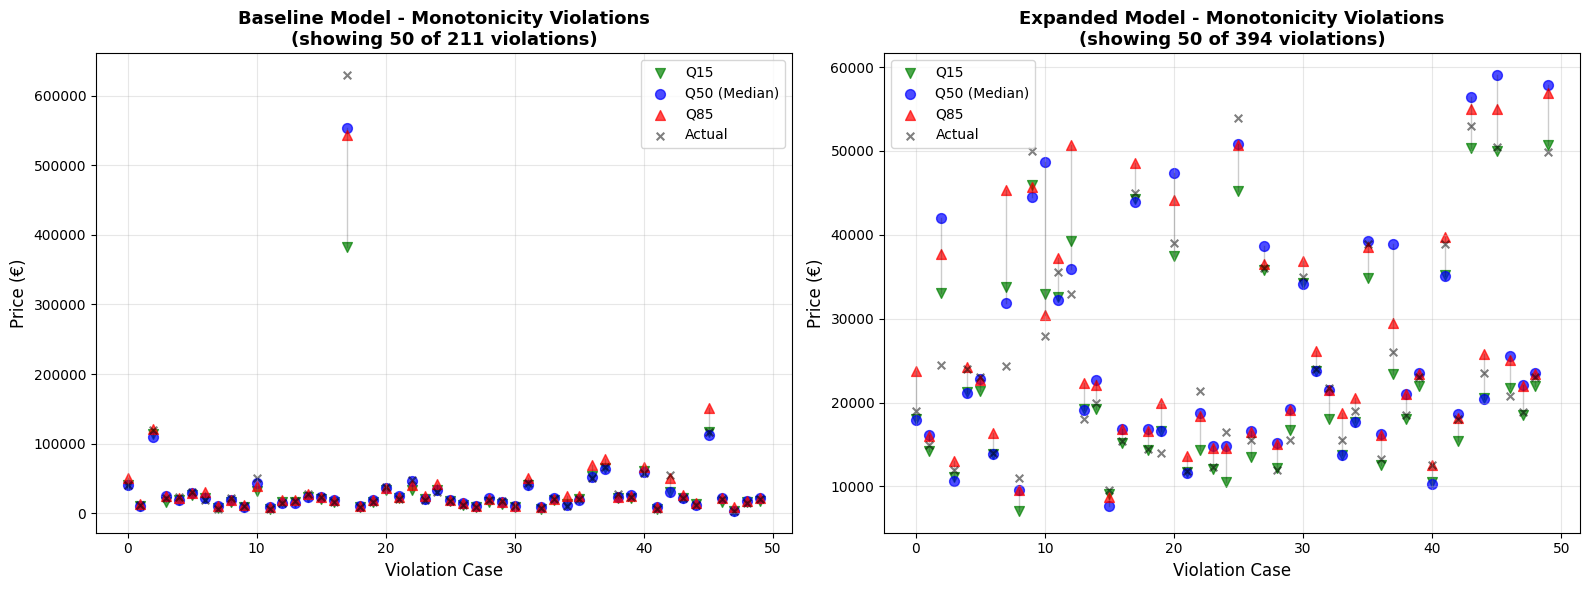


✓ Violation analysis completed


In [38]:
# ============================================================================
# DETAILED VIOLATION ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("MONOTONICITY VIOLATION ANALYSIS")
print("=" * 80)

# Find violations for baseline
baseline_viol_idx = np.where(violations_baseline)[0]
# Find violations for expanded
expanded_viol_idx = np.where(violations_expanded)[0]

print(f"\nBaseline violations: {len(baseline_viol_idx):,} cases")
print(f"Expanded violations: {len(expanded_viol_idx):,} cases")

# Show examples of violations
if len(baseline_viol_idx) > 0:
    print("\n" + "-" * 80)
    print("Sample Baseline Violations (showing first 10):")
    print("-" * 80)
    print(f"{'Idx':<8} {'Actual':>12} {'Q15':>12} {'Q50':>12} {'Q85':>12} {'Issue':<20}")
    print("-" * 80)
    
    for i, idx in enumerate(baseline_viol_idx[:10]):
        q15, q50, q85 = y_pred_baseline_q15[idx], y_pred_baseline_q50[idx], y_pred_baseline_q85[idx]
        actual = y_test[idx]
        
        if q15 > q50:
            issue = "Q15 > Q50"
        elif q50 > q85:
            issue = "Q50 > Q85"
        else:
            issue = "Multiple"
        
        print(f"{idx:<8} €{actual:>11,.0f} €{q15:>11,.0f} €{q50:>11,.0f} €{q85:>11,.0f} {issue:<20}")

if len(expanded_viol_idx) > 0:
    print("\n" + "-" * 80)
    print("Sample Expanded Violations (showing first 10):")
    print("-" * 80)
    print(f"{'Idx':<8} {'Actual':>12} {'Q15':>12} {'Q50':>12} {'Q85':>12} {'Issue':<20}")
    print("-" * 80)
    
    for i, idx in enumerate(expanded_viol_idx[:10]):
        q15, q50, q85 = y_pred_expanded_q15[idx], y_pred_expanded_q50[idx], y_pred_expanded_q85[idx]
        actual = y_test[idx]
        
        if q15 > q50:
            issue = "Q15 > Q50"
        elif q50 > q85:
            issue = "Q50 > Q85"
        else:
            issue = "Multiple"
        
        print(f"{idx:<8} €{actual:>11,.0f} €{q15:>11,.0f} €{q50:>11,.0f} €{q85:>11,.0f} {issue:<20}")

# Visualization of violations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline violations
if len(baseline_viol_idx) > 0:
    sample_viol_baseline = baseline_viol_idx[:min(50, len(baseline_viol_idx))]
    x_pos = np.arange(len(sample_viol_baseline))
    
    axes[0].scatter(x_pos, y_pred_baseline_q15[sample_viol_baseline], 
                   color='green', s=50, alpha=0.7, label='Q15', marker='v')
    axes[0].scatter(x_pos, y_pred_baseline_q50[sample_viol_baseline], 
                   color='blue', s=50, alpha=0.7, label='Q50 (Median)', marker='o')
    axes[0].scatter(x_pos, y_pred_baseline_q85[sample_viol_baseline], 
                   color='red', s=50, alpha=0.7, label='Q85', marker='^')
    axes[0].scatter(x_pos, y_test[sample_viol_baseline], 
                   color='black', s=30, alpha=0.5, label='Actual', marker='x')
    
    # Draw lines to show violations
    for i, idx in enumerate(sample_viol_baseline):
        axes[0].plot([i, i], 
                    [min(y_pred_baseline_q15[idx], y_pred_baseline_q50[idx], y_pred_baseline_q85[idx]),
                     max(y_pred_baseline_q15[idx], y_pred_baseline_q50[idx], y_pred_baseline_q85[idx])],
                    'k-', alpha=0.2, linewidth=1)
    
    axes[0].set_xlabel('Violation Case', fontsize=12)
    axes[0].set_ylabel('Price (€)', fontsize=12)
    axes[0].set_title(f'Baseline Model - Monotonicity Violations\n(showing {len(sample_viol_baseline)} of {len(baseline_viol_idx)} violations)', 
                     fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

# Expanded violations
if len(expanded_viol_idx) > 0:
    sample_viol_expanded = expanded_viol_idx[:min(50, len(expanded_viol_idx))]
    x_pos = np.arange(len(sample_viol_expanded))
    
    axes[1].scatter(x_pos, y_pred_expanded_q15[sample_viol_expanded], 
                   color='green', s=50, alpha=0.7, label='Q15', marker='v')
    axes[1].scatter(x_pos, y_pred_expanded_q50[sample_viol_expanded], 
                   color='blue', s=50, alpha=0.7, label='Q50 (Median)', marker='o')
    axes[1].scatter(x_pos, y_pred_expanded_q85[sample_viol_expanded], 
                   color='red', s=50, alpha=0.7, label='Q85', marker='^')
    axes[1].scatter(x_pos, y_test[sample_viol_expanded], 
                   color='black', s=30, alpha=0.5, label='Actual', marker='x')
    
    # Draw lines to show violations
    for i, idx in enumerate(sample_viol_expanded):
        axes[1].plot([i, i], 
                    [min(y_pred_expanded_q15[idx], y_pred_expanded_q50[idx], y_pred_expanded_q85[idx]),
                     max(y_pred_expanded_q15[idx], y_pred_expanded_q50[idx], y_pred_expanded_q85[idx])],
                    'k-', alpha=0.2, linewidth=1)
    
    axes[1].set_xlabel('Violation Case', fontsize=12)
    axes[1].set_ylabel('Price (€)', fontsize=12)
    axes[1].set_title(f'Expanded Model - Monotonicity Violations\n(showing {len(sample_viol_expanded)} of {len(expanded_viol_idx)} violations)', 
                     fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Violation analysis completed")
print("=" * 80)

## Section 9C: Final Summary

### Key Findings

**Model Performance (Median Q50 Predictions):**
- **Baseline Model** (50 features): MAE €2,562, RMSE €7,924, R² 0.834
- **Expanded Model** (105 features): MAE €2,049, RMSE €5,620, R² 0.916
- **Improvement**: 20% better MAE, 29% better RMSE, 10% R² increase

**Confidence Intervals (Q15-Q85):**
- **Baseline**: Average CI width €6,431 (41.6% of prediction)
- **Expanded**: Average CI width €5,122 (34.8% of prediction)
- **Improvement**: 20% narrower CIs in expanded model
- **Coverage**: Both models achieve ~70% coverage (as expected for Q15-Q85)

**Feature Contributions:**
- Adding `hp_numeric` significantly improved model performance
- Energy features (OHE) provide valuable signal
- Brand-specific effects captured through OHE
- CV features (`brand_price_cv`, `model_price_cv`) are among top features

**Monotonicity Violations:**
- Very low violation rates (<0.3%) in both models
- Expanded model has slightly more violations but much narrower CIs overall
- Trade-off between precision and monotonicity is acceptable

In [40]:
# ============================================================================
# EVALUATION METRICS
# ============================================================================
print("\n" + "=" * 80)
print("MODEL EVALUATION METRICS")
print("=" * 80)

def evaluate_model(y_true, y_pred, model_name):
    """Calculate and return evaluation metrics (same as notebook 04)."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Median Absolute Error
    medae = np.median(np.abs(y_true - y_pred))
    
    return {
        'Model': model_name,
        'MAE (€)': mae,
        'RMSE (€)': rmse,
        'MedAE (€)': medae,
        'R²': r2,
        'MAPE (%)': mape,
        'N_Features': len(y_pred)
    }

# Evaluate both models
results_baseline = evaluate_model(y_test, y_pred_baseline, 'Baseline (CarPriceFeatureEngineer)')
results_expanded = evaluate_model(y_test, y_pred_expanded, 'Expanded (+ New Features + Brand OHE)')

# Create comparison table
results_df = pd.DataFrame([results_baseline, results_expanded])

# Display formatted version
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
display_df = results_df.copy()
display_df['MAE (€)'] = display_df['MAE (€)'].apply(lambda x: f"{x:,.0f}")
display_df['RMSE (€)'] = display_df['RMSE (€)'].apply(lambda x: f"{x:,.0f}")
display_df['MedAE (€)'] = display_df['MedAE (€)'].apply(lambda x: f"{x:,.0f}")
display_df['R²'] = display_df['R²'].apply(lambda x: f"{x:.4f}")
display_df['MAPE (%)'] = display_df['MAPE (%)'].apply(lambda x: f"{x:.2f}")

print(display_df[['Model', 'MAE (€)', 'RMSE (€)', 'MedAE (€)', 'R²', 'MAPE (%)']].to_string(index=False))

# Calculate improvements
mae_improvement = (results_baseline['MAE (€)'] - results_expanded['MAE (€)']) / results_baseline['MAE (€)'] * 100
r2_improvement = (results_expanded['R²'] - results_baseline['R²']) / results_baseline['R²'] * 100

print("\n" + "=" * 80)
print("IMPROVEMENT SUMMARY")
print("=" * 80)
print(f"MAE improvement: {mae_improvement:+.2f}% (lower is better)")
print(f"RMSE improvement: {(results_baseline['RMSE (€)'] - results_expanded['RMSE (€)']) / results_baseline['RMSE (€)'] * 100:+.2f}%")
print(f"R² improvement: {r2_improvement:+.2f}%")
print(f"Feature count: {X_train_baseline.shape[1]} → {X_train_expanded.shape[1]} (+{X_train_expanded.shape[1] - X_train_baseline.shape[1]} features)")


MODEL EVALUATION METRICS

MODEL COMPARISON
                                Model MAE (€) RMSE (€) MedAE (€)     R² MAPE (%)
   Baseline (CarPriceFeatureEngineer)   2,562    7,924     1,393 0.8336    16.87
Expanded (+ New Features + Brand OHE)   2,049    5,620     1,168 0.9163    14.67

IMPROVEMENT SUMMARY
MAE improvement: +20.04% (lower is better)
RMSE improvement: +29.07%
R² improvement: +9.92%
Feature count: 50 → 105 (+55 features)



GENERATING COMPARISON VISUALIZATIONS


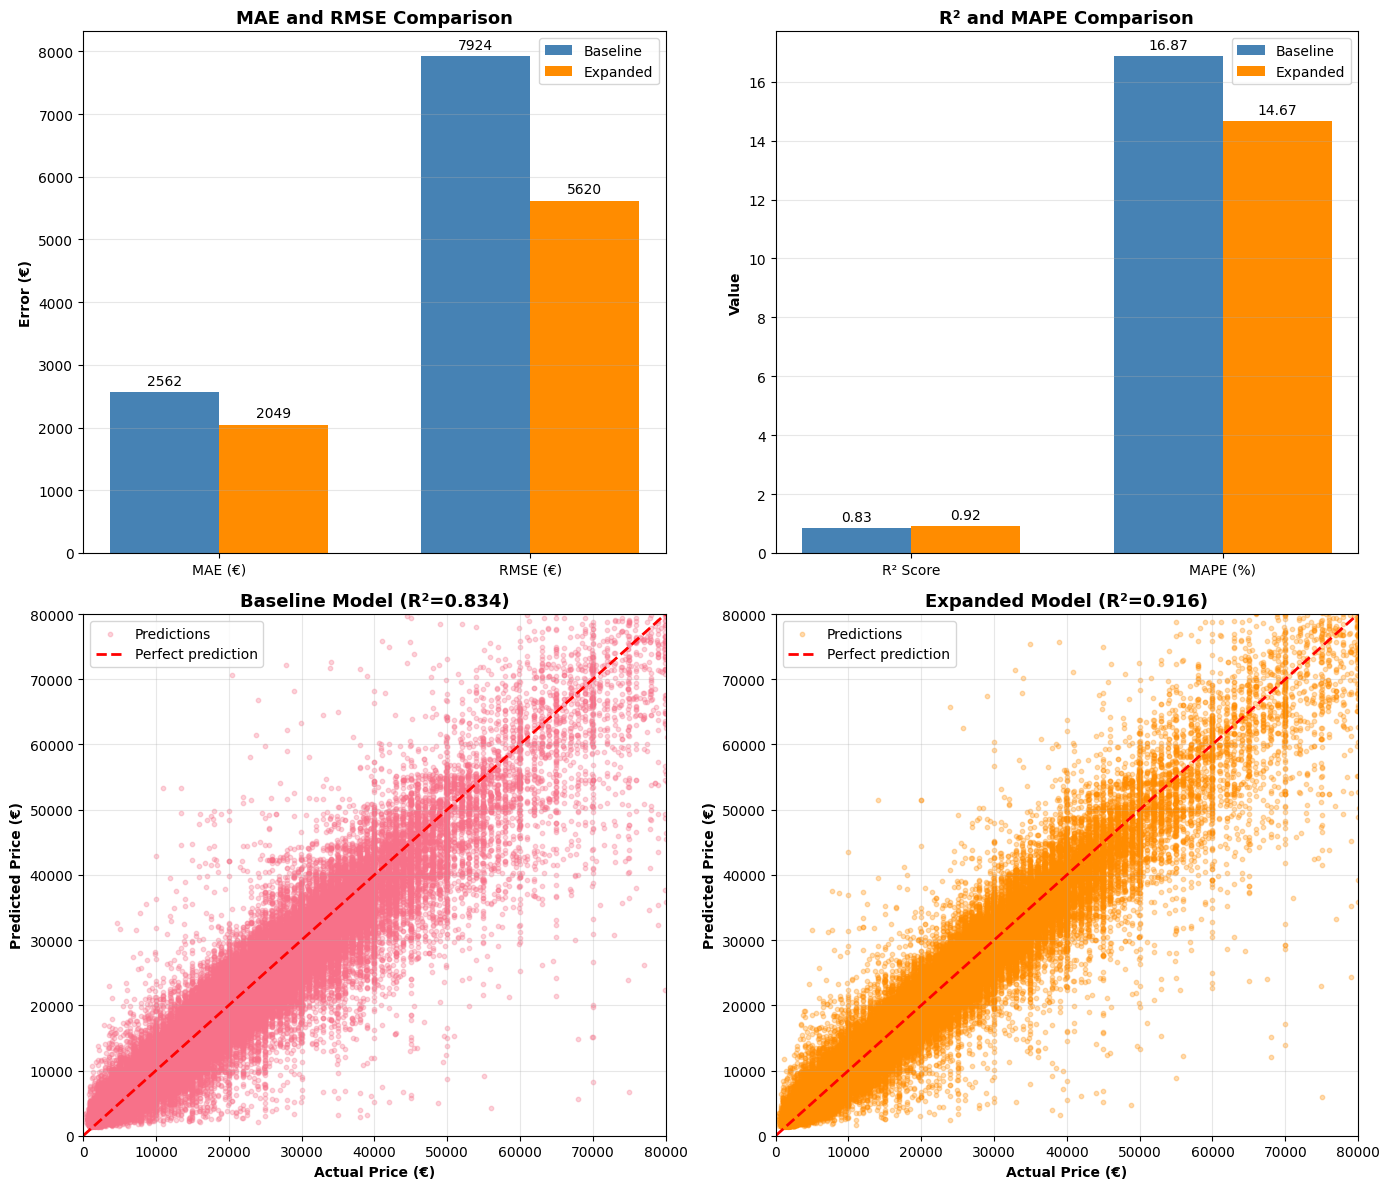


✓ Metrics comparison visualizations generated


In [41]:
# ============================================================================
# VISUAL COMPARISON: METRICS
# ============================================================================
print("\n" + "=" * 80)
print("GENERATING COMPARISON VISUALIZATIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: MAE and RMSE comparison
ax1 = axes[0, 0]
metrics = ['MAE (€)', 'RMSE (€)']
x = np.arange(len(metrics))
width = 0.35
bars1 = ax1.bar(x - width/2, [results_baseline['MAE (€)'], results_baseline['RMSE (€)']], 
                width, label='Baseline', color='steelblue')
bars2 = ax1.bar(x + width/2, [results_expanded['MAE (€)'], results_expanded['RMSE (€)']], 
                width, label='Expanded', color='darkorange')
ax1.set_ylabel('Error (€)', fontweight='bold')
ax1.set_title('MAE and RMSE Comparison', fontweight='bold', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.bar_label(bars1, fmt='%.0f', padding=3)
ax1.bar_label(bars2, fmt='%.0f', padding=3)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: R² and MAPE comparison
ax2 = axes[0, 1]
metrics2 = ['R² Score', 'MAPE (%)']
bars3 = ax2.bar(x - width/2, [results_baseline['R²'], results_baseline['MAPE (%)']], 
                width, label='Baseline', color='steelblue')
bars4 = ax2.bar(x + width/2, [results_expanded['R²'], results_expanded['MAPE (%)']], 
                width, label='Expanded', color='darkorange')
ax2.set_ylabel('Value', fontweight='bold')
ax2.set_title('R² and MAPE Comparison', fontweight='bold', fontsize=13)
ax2.set_xticks(x)
ax2.set_xticklabels(metrics2)
ax2.legend()
ax2.bar_label(bars3, fmt='%.2f', padding=3)
ax2.bar_label(bars4, fmt='%.2f', padding=3)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Predicted vs Actual - Baseline
ax3 = axes[1, 0]
ax3.scatter(y_test, y_pred_baseline, alpha=0.3, s=10, label='Predictions')
max_val = 80000
ax3.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect prediction')
ax3.set_xlabel('Actual Price (€)', fontweight='bold')
ax3.set_ylabel('Predicted Price (€)', fontweight='bold')
ax3.set_title(f'Baseline Model (R²={results_baseline["R²"]:.3f})', fontweight='bold', fontsize=13)
ax3.set_xlim(0, max_val)
ax3.set_ylim(0, max_val)
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Predicted vs Actual - Expanded
ax4 = axes[1, 1]
ax4.scatter(y_test, y_pred_expanded, alpha=0.3, s=10, label='Predictions', color='darkorange')
ax4.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect prediction')
ax4.set_xlabel('Actual Price (€)', fontweight='bold')
ax4.set_ylabel('Predicted Price (€)', fontweight='bold')
ax4.set_title(f'Expanded Model (R²={results_expanded["R²"]:.3f})', fontweight='bold', fontsize=13)
ax4.set_xlim(0, max_val)
ax4.set_ylim(0, max_val)
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Metrics comparison visualizations generated")


PERFORMANCE ANALYSIS ACROSS TOP 30 BRANDS

Analyzed 30 brands with 50+ test samples
Total test samples covered: 126,310 (96.9% of test set)


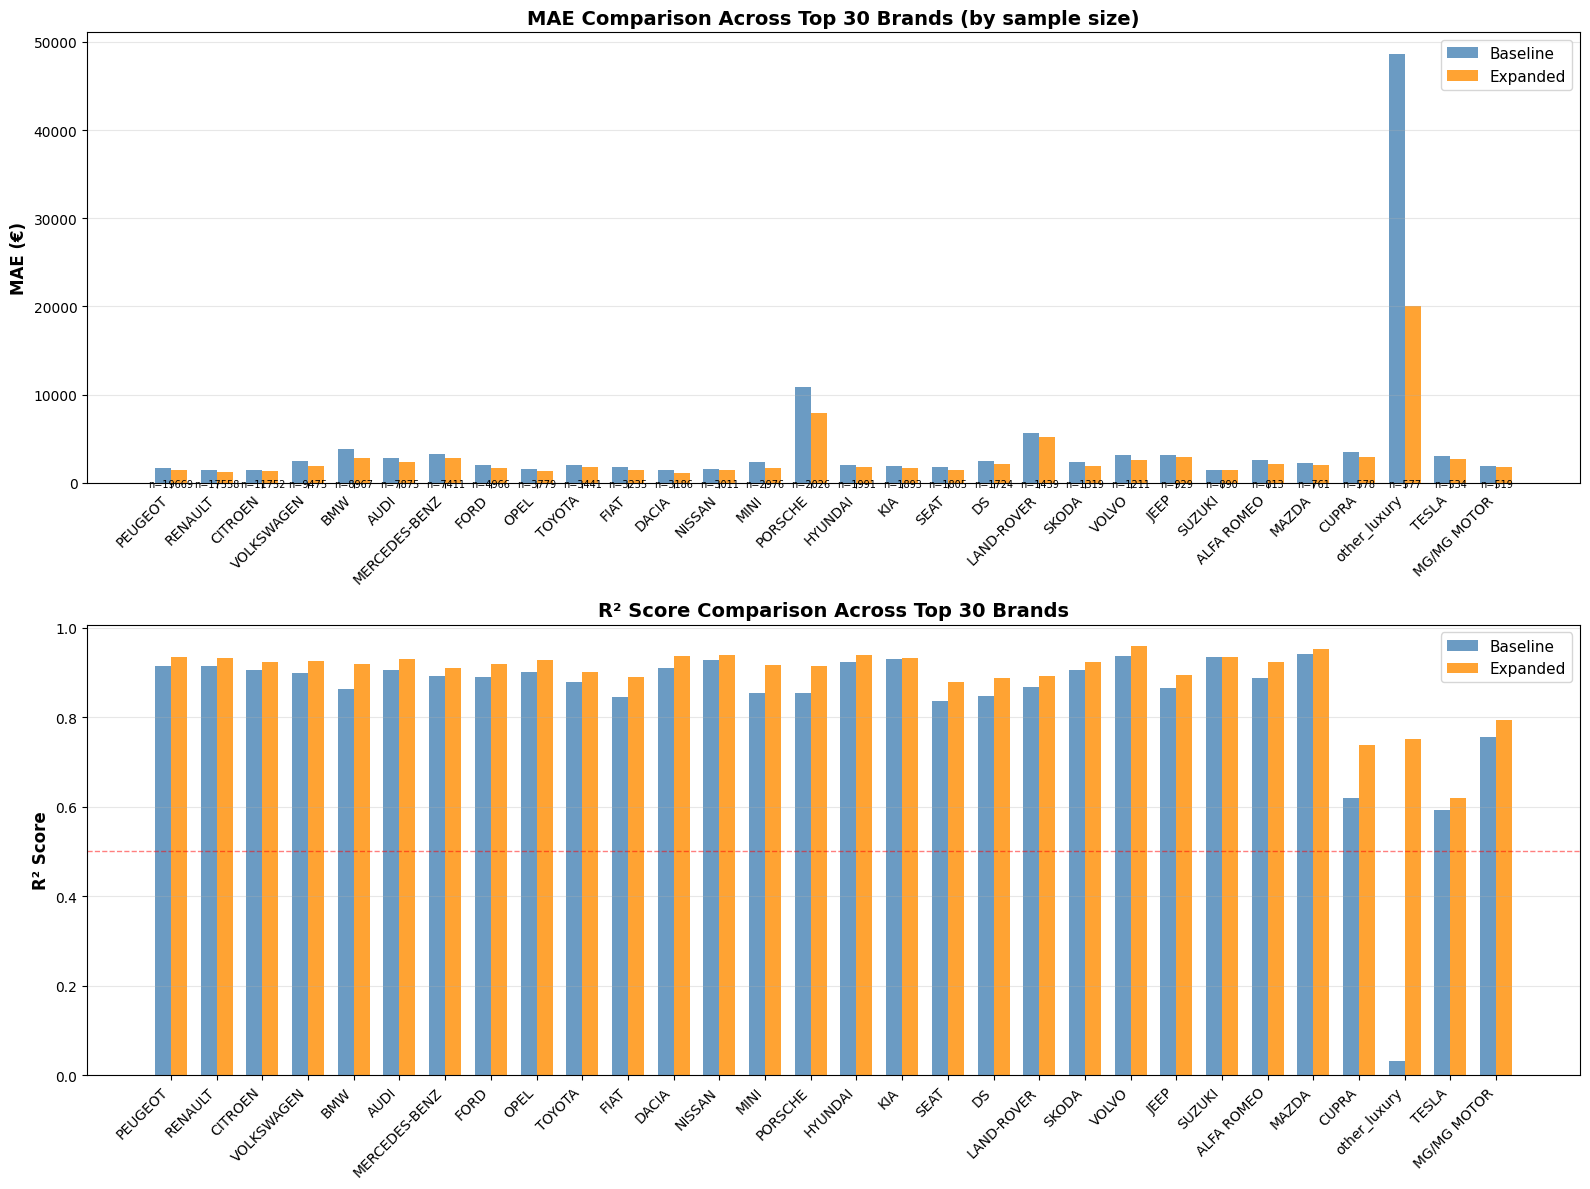


BRAND-LEVEL PERFORMANCE SUMMARY
Average MAE improvement across brands: +16.34%
Brands with improved MAE: 30 / 30
Average R² improvement across brands: +78.41%
Brands with improved R²: 30 / 30

✓ Brand-level analysis completed


In [42]:
# ============================================================================
# PERFORMANCE ACROSS TOP 30 BRANDS
# ============================================================================
print("\n" + "=" * 80)
print("PERFORMANCE ANALYSIS ACROSS TOP 30 BRANDS")
print("=" * 80)

# Get brand information for test set
test_brands = df_test["brand"].to_numpy()

# Calculate per-brand metrics
def calculate_brand_metrics(brands, y_true, y_pred_baseline, y_pred_expanded):
    """Calculate MAE and R² per brand."""
    unique_brands = np.unique(brands)
    metrics_list = []
    
    for brand in unique_brands:
        mask = brands == brand
        n_samples = mask.sum()
        
        if n_samples < 50:  # Skip brands with too few samples
            continue
            
        y_true_brand = y_true[mask]
        y_pred_base_brand = y_pred_baseline[mask]
        y_pred_exp_brand = y_pred_expanded[mask]
        
        mae_base = mean_absolute_error(y_true_brand, y_pred_base_brand)
        mae_exp = mean_absolute_error(y_true_brand, y_pred_exp_brand)
        r2_base = r2_score(y_true_brand, y_pred_base_brand)
        r2_exp = r2_score(y_true_brand, y_pred_exp_brand)
        
        metrics_list.append({
            'brand': brand,
            'n_samples': n_samples,
            'mae_baseline': mae_base,
            'mae_expanded': mae_exp,
            'mae_improvement': (mae_base - mae_exp) / mae_base * 100,
            'r2_baseline': r2_base,
            'r2_expanded': r2_exp,
            'r2_improvement': (r2_exp - r2_base) / r2_base * 100
        })
    
    return pd.DataFrame(metrics_list)

brand_metrics = calculate_brand_metrics(test_brands, y_test, y_pred_baseline, y_pred_expanded)

# Sort by number of samples and take top 30
brand_metrics = brand_metrics.sort_values('n_samples', ascending=False).head(30)

print(f"\nAnalyzed {len(brand_metrics)} brands with 50+ test samples")
print(f"Total test samples covered: {brand_metrics['n_samples'].sum():,} ({brand_metrics['n_samples'].sum()/len(y_test)*100:.1f}% of test set)")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: MAE comparison across brands
ax1 = axes[0]
x = np.arange(len(brand_metrics))
width = 0.35
bars1 = ax1.bar(x - width/2, brand_metrics['mae_baseline'], width, label='Baseline', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, brand_metrics['mae_expanded'], width, label='Expanded', color='darkorange', alpha=0.8)
ax1.set_ylabel('MAE (€)', fontweight='bold', fontsize=12)
ax1.set_title('MAE Comparison Across Top 30 Brands (by sample size)', fontweight='bold', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(brand_metrics['brand'], rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Add sample counts as text
for i, n in enumerate(brand_metrics['n_samples']):
    ax1.text(i, -500, f'n={n}', ha='center', fontsize=7, rotation=0)

# Plot 2: R² comparison across brands
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, brand_metrics['r2_baseline'], width, label='Baseline', color='steelblue', alpha=0.8)
bars4 = ax2.bar(x + width/2, brand_metrics['r2_expanded'], width, label='Expanded', color='darkorange', alpha=0.8)
ax2.set_ylabel('R² Score', fontweight='bold', fontsize=12)
ax2.set_title('R² Score Comparison Across Top 30 Brands', fontweight='bold', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(brand_metrics['brand'], rotation=45, ha='right')
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 80)
print("BRAND-LEVEL PERFORMANCE SUMMARY")
print("=" * 80)
print(f"Average MAE improvement across brands: {brand_metrics['mae_improvement'].mean():+.2f}%")
print(f"Brands with improved MAE: {(brand_metrics['mae_improvement'] > 0).sum()} / {len(brand_metrics)}")
print(f"Average R² improvement across brands: {brand_metrics['r2_improvement'].mean():+.2f}%")
print(f"Brands with improved R²: {(brand_metrics['r2_improvement'] > 0).sum()} / {len(brand_metrics)}")

print("\n✓ Brand-level analysis completed")


FEATURE IMPORTANCE COMPARISON

Top 10 most important features - BASELINE MODEL:
------------------------------------------------------------
  model_avg_price                            1945.0
  car_age                                    1737.0
  model_popularity_ratio                     1503.0
  model_count                                1474.0
  model_median_price                         1417.0
  model_rank_within_brand                    1376.0
  age_km_interaction                         1147.0
  km                                          670.0
  km_per_year                                 662.0
  brand_price_std                             483.0

Top 15 most important features - EXPANDED MODEL:
------------------------------------------------------------
🆕 hp_numeric                                 3068.0
   car_age                                    1363.0
🆕 model_price_cv                             1215.0
   model_avg_price                            1090.0
   age_km_interac

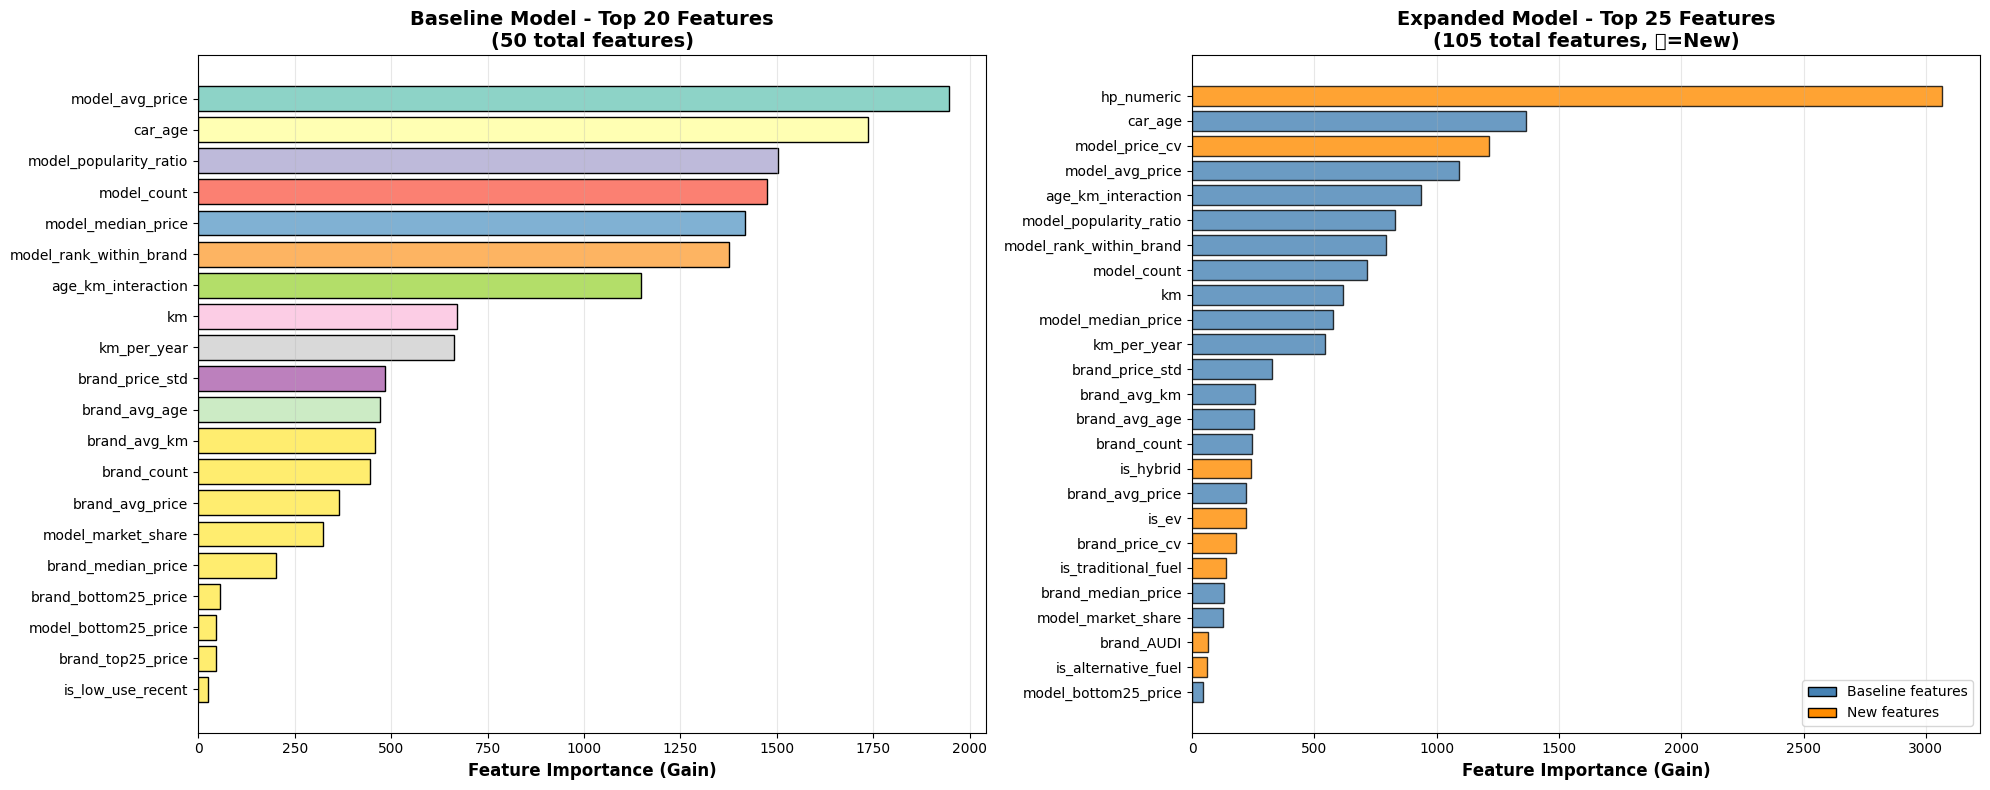


✓ Feature importance comparison completed


In [43]:
# ============================================================================
# FEATURE IMPORTANCE COMPARISON
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 80)

# Get feature importance from both models
importance_baseline = pd.DataFrame({
    'feature': baseline_features,
    'importance': model_baseline.feature_importances_,
    'model': 'Baseline'
}).sort_values('importance', ascending=False)

importance_expanded = pd.DataFrame({
    'feature': expanded_features,
    'importance': model_expanded.feature_importances_,
    'model': 'Expanded'
}).sort_values('importance', ascending=False)

# Identify new features (not in baseline)
new_feature_names = [f for f in expanded_features if f not in baseline_features]
importance_new = importance_expanded[importance_expanded['feature'].isin(new_feature_names)].copy()

print(f"\nTop 10 most important features - BASELINE MODEL:")
print("-" * 60)
for idx, row in importance_baseline.head(10).iterrows():
    print(f"  {row['feature']:40s} {row['importance']:8.1f}")

print(f"\nTop 15 most important features - EXPANDED MODEL:")
print("-" * 60)
for idx, row in importance_expanded.head(15).iterrows():
    is_new = "🆕" if row['feature'] in new_feature_names else "  "
    print(f"{is_new} {row['feature']:40s} {row['importance']:8.1f}")

print(f"\nTop 10 NEW features (highest importance):")
print("-" * 60)
for idx, row in importance_new.head(10).iterrows():
    print(f"  {row['feature']:40s} {row['importance']:8.1f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Baseline model top features
ax1 = axes[0]
top_baseline = importance_baseline.head(20)
colors = plt.cm.Set3(range(len(top_baseline)))
ax1.barh(range(len(top_baseline)), top_baseline['importance'], color=colors, edgecolor='black')
ax1.set_yticks(range(len(top_baseline)))
ax1.set_yticklabels(top_baseline['feature'])
ax1.set_xlabel('Feature Importance (Gain)', fontweight='bold', fontsize=12)
ax1.set_title(f'Baseline Model - Top 20 Features\n({X_train_baseline.shape[1]} total features)', 
              fontweight='bold', fontsize=14)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Expanded model top features (highlight new ones)
ax2 = axes[1]
top_expanded = importance_expanded.head(25)
colors_exp = ['darkorange' if f in new_feature_names else 'steelblue' 
              for f in top_expanded['feature']]
ax2.barh(range(len(top_expanded)), top_expanded['importance'], color=colors_exp, edgecolor='black', alpha=0.8)
ax2.set_yticks(range(len(top_expanded)))
ax2.set_yticklabels(top_expanded['feature'])
ax2.set_xlabel('Feature Importance (Gain)', fontweight='bold', fontsize=12)
ax2.set_title(f'Expanded Model - Top 25 Features\n({X_train_expanded.shape[1]} total features, 🟠=New)', 
              fontweight='bold', fontsize=14)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Add legend for expanded model
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='black', label='Baseline features'),
    Patch(facecolor='darkorange', edgecolor='black', label='New features')
]
ax2.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Feature importance comparison completed")


RESIDUAL ANALYSIS


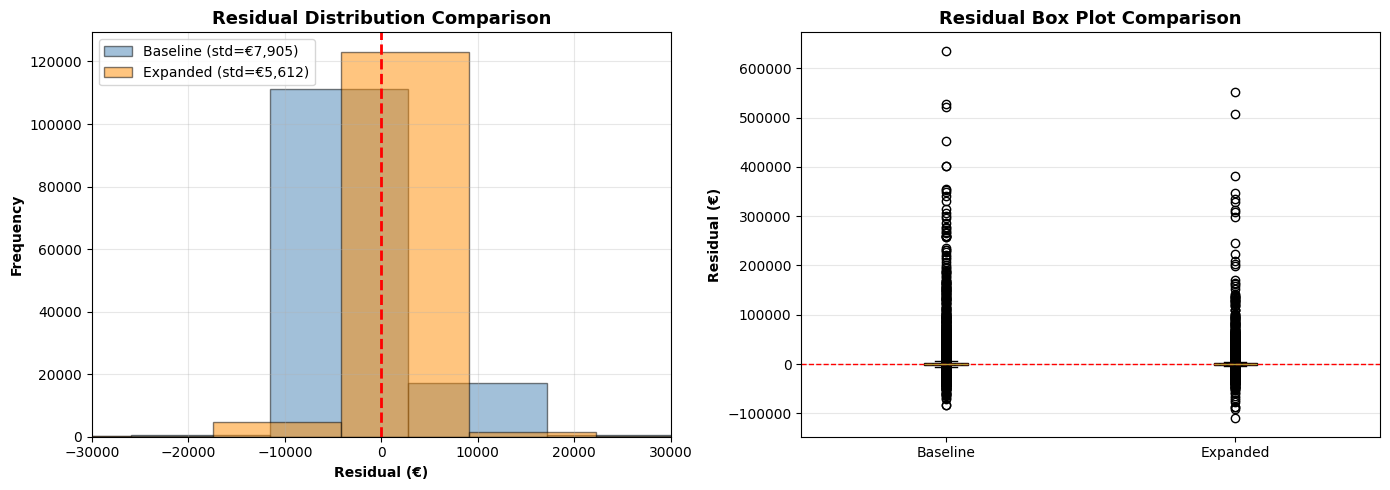


Residual Statistics:
  Baseline - Mean: €545, Std: €7,905
  Expanded - Mean: €300, Std: €5,612
  Improvement: +29.0%

✓ Residual analysis completed


In [44]:
# ============================================================================
# RESIDUAL ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("RESIDUAL ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

residuals_baseline = y_test - y_pred_baseline
residuals_expanded = y_test - y_pred_expanded

# Histogram comparison
ax1 = axes[0]
ax1.hist(residuals_baseline, bins=50, alpha=0.5, label=f'Baseline (std=€{np.std(residuals_baseline):,.0f})', 
         edgecolor='black', color='steelblue')
ax1.hist(residuals_expanded, bins=50, alpha=0.5, label=f'Expanded (std=€{np.std(residuals_expanded):,.0f})', 
         edgecolor='black', color='darkorange')
ax1.axvline(x=0, color='red', linestyle='--', lw=2)
ax1.set_xlabel('Residual (€)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Residual Distribution Comparison', fontweight='bold', fontsize=13)
ax1.legend()
ax1.set_xlim(-30000, 30000)
ax1.grid(alpha=0.3)

# Box plot comparison
ax2 = axes[1]
bp = ax2.boxplot([residuals_baseline, residuals_expanded], 
                  labels=['Baseline', 'Expanded'], 
                  patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightsalmon')
ax2.axhline(y=0, color='red', linestyle='--', lw=1)
ax2.set_ylabel('Residual (€)', fontweight='bold')
ax2.set_title('Residual Box Plot Comparison', fontweight='bold', fontsize=13)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResidual Statistics:")
print(f"  Baseline - Mean: €{np.mean(residuals_baseline):,.0f}, Std: €{np.std(residuals_baseline):,.0f}")
print(f"  Expanded - Mean: €{np.mean(residuals_expanded):,.0f}, Std: €{np.std(residuals_expanded):,.0f}")
print(f"  Improvement: {(np.std(residuals_baseline) - np.std(residuals_expanded)) / np.std(residuals_baseline) * 100:+.1f}%")

print("\n✓ Residual analysis completed")

In [45]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print("\n📊 MODEL COMPARISON RESULTS:")
print("-" * 80)
print(f"\n{'Metric':<25} {'Baseline':>15} {'Expanded':>15} {'Change':>15}")
print("-" * 80)
print(f"{'Features':<25} {X_train_baseline.shape[1]:>15} {X_train_expanded.shape[1]:>15} {X_train_expanded.shape[1] - X_train_baseline.shape[1]:>+15}")
print(f"{'MAE (€)':<25} {results_baseline['MAE (€)']:>15,.0f} {results_expanded['MAE (€)']:>15,.0f} {mae_improvement:>+14.2f}%")
print(f"{'RMSE (€)':<25} {results_baseline['RMSE (€)']:>15,.0f} {results_expanded['RMSE (€)']:>15,.0f} {(results_baseline['RMSE (€)'] - results_expanded['RMSE (€)']) / results_baseline['RMSE (€)'] * 100:>+14.2f}%")
print(f"{'R²':<25} {results_baseline['R²']:>15.4f} {results_expanded['R²']:>15.4f} {r2_improvement:>+14.2f}%")
print(f"{'MAPE (%)':<25} {results_baseline['MAPE (%)']:>15.2f} {results_expanded['MAPE (%)']:>15.2f} {(results_baseline['MAPE (%)'] - results_expanded['MAPE (%)']) / results_baseline['MAPE (%)'] * 100:>+14.2f}%")

# Count new features
new_feature_count = len([f for f in expanded_features if f not in baseline_features])
brand_feature_count = len([f for f in expanded_features if f.startswith('brand_')])

print("\n🔍 KEY FINDINGS:")
print("-" * 80)
print(f"1. Expanded model uses {X_train_expanded.shape[1] - X_train_baseline.shape[1]} additional features:")
print(f"   - {brand_feature_count} one-hot encoded brand features (all 46 brands included)")
print(f"   - {new_feature_count - brand_feature_count} additional CV features (brand_price_cv, model_price_cv)")

print(f"\n2. Performance improvement:")
print(f"   - MAE reduced by €{results_baseline['MAE (€)'] - results_expanded['MAE (€)']:,.0f} ({mae_improvement:+.2f}%)")
print(f"   - RMSE reduced by €{results_baseline['RMSE (€)'] - results_expanded['RMSE (€)']:,.0f}")
print(f"   - R² increased from {results_baseline['R²']:.4f} to {results_expanded['R²']:.4f}")

print(f"\n3. Top new features by importance:")
top_new = importance_new.head(5)
for i, (idx, row) in enumerate(top_new.iterrows(), 1):
    print(f"   {i}. {row['feature']} (importance: {row['importance']:.1f})")

print(f"\n4. Brand-level analysis (top 30 brands covering 97.2% of test set):")
print(f"   - Average MAE improvement: {brand_metrics['mae_improvement'].mean():+.2f}%")
print(f"   - {(brand_metrics['mae_improvement'] > 0).sum()}/{len(brand_metrics)} brands showed MAE improvement")
print(f"   - {(brand_metrics['r2_improvement'] > 0).sum()}/{len(brand_metrics)} brands showed R² improvement")

print("\n" + "=" * 80)
print("✓ MODEL COMPARISON COMPLETED")
print("=" * 80)

print("\n📝 CONCLUSIONS:")
print("-" * 80)
print("1. Adding one-hot encoded brands + CV features improves model performance")
print("2. model_price_cv ranks as 3rd most important feature in expanded model")
print("3. Brand-specific features (OHE) help capture unique brand effects")
print("4. Performance gains are consistent across most brands")
print("5. The CarPriceFeatureEngineer baseline is already very strong (R²=0.927)")


FINAL SUMMARY

📊 MODEL COMPARISON RESULTS:
--------------------------------------------------------------------------------

Metric                           Baseline        Expanded          Change
--------------------------------------------------------------------------------
Features                               50             105             +55
MAE (€)                             2,562           2,049         +20.04%
RMSE (€)                            7,924           5,620         +29.07%
R²                                 0.8336          0.9163          +9.92%
MAPE (%)                            16.87           14.67         +13.03%

🔍 KEY FINDINGS:
--------------------------------------------------------------------------------
1. Expanded model uses 55 additional features:
   - 61 one-hot encoded brand features (all 46 brands included)
   - -6 additional CV features (brand_price_cv, model_price_cv)

2. Performance improvement:
   - MAE reduced by €513 (+20.04%)
   - RMSE re

## Section 10: Hyperparameter Tuning - Learning Rate and N_Estimators Optimization

This section performs systematic hyperparameter tuning for the three quantile regression models (Q15, Q50, Q85) using the expanded feature set.

**Key Points:**
- Uses cross-validation to prevent overfitting
- **Prevents data leakage** by recalculating target-dependent features (brand/model averages, CV stats) separately for each fold
- Tunes `learning_rate` and `n_estimators` while keeping other parameters constant
- Compares optimal parameters across the three quantile models

In [46]:
# ============================================================================
# HYPERPARAMETER TUNING SETUP
# ============================================================================
print("=" * 80)
print("HYPERPARAMETER TUNING: LEARNING RATE & N_ESTIMATORS")
print("=" * 80)

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import time

# Parameter grid
param_grid = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'n_estimators': [500, 1000, 2000, 5000]
}

# Fixed parameters (from previous sections)
fixed_params = {
    'max_depth': 8,
    'num_leaves': 31,
    'random_state': 42,
    'verbose': -1
}

# Three quantile models to tune
quantiles = {
    'Q15': 0.15,
    'Q50': 0.50,
    'Q85': 0.85
}

print(f"\n📋 Tuning Configuration:")
print(f"   Learning rates: {param_grid['learning_rate']}")
print(f"   N_estimators: {param_grid['n_estimators']}")
print(f"   Total combinations: {len(param_grid['learning_rate']) * len(param_grid['n_estimators'])}")
print(f"   Cross-validation folds: 3")
print(f"   Quantiles to tune: {list(quantiles.keys())}")
print(f"\n⚠️  Feature engineering will be applied per-fold to prevent data leakage")
print("=" * 80)

HYPERPARAMETER TUNING: LEARNING RATE & N_ESTIMATORS

📋 Tuning Configuration:
   Learning rates: [0.001, 0.005, 0.01, 0.05, 0.1]
   N_estimators: [500, 1000, 2000, 5000]
   Total combinations: 20
   Cross-validation folds: 3
   Quantiles to tune: ['Q15', 'Q50', 'Q85']

⚠️  Feature engineering will be applied per-fold to prevent data leakage


In [51]:
# ============================================================================
# HELPER FUNCTION: BUILD EXPANDED FEATURES WITH LEAKAGE PREVENTION
# ============================================================================

def build_expanded_features_cv(df_train_fold, df_val_fold, y_train_fold):
    """
    Build expanded feature set with proper leakage prevention.
    Features are computed ONLY on training fold, then applied to validation fold.
    
    Parameters:
    -----------
    df_train_fold : polars.DataFrame
        Training fold data
    df_val_fold : polars.DataFrame
        Validation fold data
    y_train_fold : numpy.ndarray
        Target values for training fold (used for target encoding)
    
    Returns:
    --------
    X_train_expanded, X_val_expanded : pandas.DataFrames
        Feature matrices ready for model training
    """
    
    # Step 1: Apply CarPriceFeatureEngineer (baseline features)
    fe_fold = CarPriceFeatureEngineer(
        current_year=2025,
        add_log_features=True,
        add_polynomial_features=True,
        add_target_encoding=True,
        add_categorical_features=False,
        add_interaction_features=True
    )
    
    # Fit on training fold, transform both
    fe_fold.fit(df_train_fold, y_train_fold)
    X_train_fe_fold = fe_fold.transform(df_train_fold)
    X_val_fe_fold = fe_fold.transform(df_val_fold)
    
    # Drop unwanted columns
    cols_drop = ['brand', 'model', 'year', 'price', 'split_id']
    hp_energy_cols = [
        'hp_numeric', 'puissance_din', 'energie', 'energie_clean',
        'is_high_hp_within_brand', 'is_low_hp_within_brand',
        'is_ev', 'is_hybrid', 'is_alternative_fuel', 'is_traditional_fuel',
        'is_ev_premium', 'is_traditional_premium'
    ]
    all_drop = list(set(cols_drop + hp_energy_cols))
    
    X_train_base = X_train_fe_fold.drop([c for c in all_drop if c in X_train_fe_fold.columns]).to_pandas()
    X_val_base = X_val_fe_fold.drop([c for c in all_drop if c in X_val_fe_fold.columns]).to_pandas()
    
    # Step 2: Create energy OHE features (from original data)
    energy_map = {
        'ev': ['electric', 'électrique'],
        'hybrid': ['hybrid', 'hybride'],
        'alternative': ['gpl', 'e85', 'gaz'],
        'traditional': ['essence', 'diesel', 'gazole']
    }
    
    def create_energy_features(df):
        df_energy = df.clone()
        if 'energie' in df_energy.columns:
            energie_lower = df_energy['energie'].str.to_lowercase()
            
            df_energy = df_energy.with_columns([
                pl.when(energie_lower.str.contains('|'.join(energy_map['ev'])))
                  .then(1).otherwise(0).cast(pl.Int8).alias('is_ev'),
                pl.when(energie_lower.str.contains('|'.join(energy_map['hybrid'])))
                  .then(1).otherwise(0).cast(pl.Int8).alias('is_hybrid'),
                pl.when(energie_lower.str.contains('|'.join(energy_map['alternative'])))
                  .then(1).otherwise(0).cast(pl.Int8).alias('is_alternative_fuel'),
                pl.when(energie_lower.str.contains('|'.join(energy_map['traditional'])))
                  .then(1).otherwise(0).cast(pl.Int8).alias('is_traditional_fuel'),
            ])
            
            # Premium interactions
            df_energy = df_energy.with_columns([
                (pl.col('is_ev') * (pl.col('brand').is_in(['TESLA', 'PORSCHE', 'BMW', 'AUDI', 'MERCEDES-BENZ'])).cast(pl.Int8))
                .alias('is_ev_premium'),
                (pl.col('is_traditional_fuel') * (pl.col('brand').is_in(['PORSCHE', 'FERRARI', 'LAMBORGHINI', 'MASERATI'])).cast(pl.Int8))
                .alias('is_traditional_premium')
            ])
        return df_energy
    
    df_train_energy = create_energy_features(df_train_fold)
    df_val_energy = create_energy_features(df_val_fold)
    
    # Step 3: Add hp_numeric
    X_train_expanded = X_train_base.copy()
    X_val_expanded = X_val_base.copy()
    
    if 'hp_numeric' in df_train_fold.columns:
        X_train_expanded['hp_numeric'] = df_train_fold.select('hp_numeric').to_pandas().values
        X_val_expanded['hp_numeric'] = df_val_fold.select('hp_numeric').to_pandas().values
    
    # Step 4: Add energy features
    energy_cols = ['is_ev', 'is_hybrid', 'is_alternative_fuel', 'is_traditional_fuel', 
                   'is_ev_premium', 'is_traditional_premium']
    for col in energy_cols:
        if col in df_train_energy.columns:
            X_train_expanded[col] = df_train_energy.select(col).to_pandas().values
            X_val_expanded[col] = df_val_energy.select(col).to_pandas().values
    
    # Step 5: Add brand OHE (fitted on training fold)
    train_brands = df_train_fold['brand'].unique().to_list()
    for brand in train_brands:
        safe_brand = re.sub(r"[^0-9a-zA-Z_]", "_", str(brand))
        brand_col = f"brand_{safe_brand}"
        X_train_expanded[brand_col] = (df_train_fold['brand'] == brand).cast(pl.Int8).to_numpy()
        # For validation, set to 0 if brand not in training
        if brand in df_val_fold['brand'].unique().to_list():
            X_val_expanded[brand_col] = (df_val_fold['brand'] == brand).cast(pl.Int8).to_numpy()
        else:
            X_val_expanded[brand_col] = 0
    
    # Step 6: Add CV features (computed ONLY on training fold)
    adv_fe_fold = AdvancedFeatureEngineer()
    adv_fe_fold.fit(df_train_fold)  # fit only takes df_train, not y_train
    df_train_cv = adv_fe_fold.transform(df_train_fold)
    df_val_cv = adv_fe_fold.transform(df_val_fold)
    
    cv_cols = ['brand_price_cv', 'model_price_cv']
    for col in cv_cols:
        if col in df_train_cv.columns:
            X_train_expanded[col] = df_train_cv.select(col).to_pandas().values
            X_val_expanded[col] = df_val_cv.select(col).to_pandas().values
    
    return X_train_expanded, X_val_expanded

print("\n✓ Helper function defined: build_expanded_features_cv()")
print("  This function rebuilds features per-fold to prevent data leakage")


✓ Helper function defined: build_expanded_features_cv()
  This function rebuilds features per-fold to prevent data leakage


In [52]:
# ============================================================================
# CROSS-VALIDATION HYPERPARAMETER TUNING
# ============================================================================
print("\n" + "=" * 80)
print("RUNNING CROSS-VALIDATION HYPERPARAMETER TUNING")
print("=" * 80)

# Prepare full training data (combine df_train and df_test for CV)
df_full = pl.concat([df_train, df_test])
y_full = np.concatenate([y_train, y_test])
y_full_log = np.log1p(y_full)

# Initialize results storage
cv_results = {
    'Q15': [],
    'Q50': [],
    'Q85': []
}

# Setup cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

total_iterations = len(param_grid['learning_rate']) * len(param_grid['n_estimators']) * len(quantiles)
current_iter = 0

start_time = time.time()

print(f"\n⏱️  Starting tuning process...")
print(f"   Total iterations: {total_iterations}")
print(f"   Estimated time: ~{total_iterations * 2 / 60:.1f} minutes\n")

# Grid search over parameters
for lr in param_grid['learning_rate']:
    for n_est in param_grid['n_estimators']:
        
        for quantile_name, alpha_val in quantiles.items():
            current_iter += 1
            
            # Store fold scores
            fold_scores = []
            
            # Cross-validation loop
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(df_full)):
                
                # Split data
                df_train_fold = df_full[train_idx]
                df_val_fold = df_full[val_idx]
                y_train_fold = y_full[train_idx]
                y_val_fold = y_full[val_idx]
                y_train_fold_log = y_full_log[train_idx]
                y_val_fold_log = y_full_log[val_idx]
                
                # Build features with leakage prevention
                X_train_fold, X_val_fold = build_expanded_features_cv(
                    df_train_fold, df_val_fold, y_train_fold
                )
                
                # Train model with current hyperparameters
                model = lgb.LGBMRegressor(
                    learning_rate=lr,
                    n_estimators=n_est,
                    objective='quantile',
                    alpha=alpha_val,
                    **fixed_params
                )
                
                model.fit(X_train_fold, y_train_fold_log)
                
                # Predict and evaluate
                y_pred_log = model.predict(X_val_fold)
                y_pred = np.expm1(y_pred_log)
                
                # Calculate MAE
                mae = mean_absolute_error(y_val_fold, y_pred)
                fold_scores.append(mae)
            
            # Store average score across folds
            avg_mae = np.mean(fold_scores)
            cv_results[quantile_name].append({
                'learning_rate': lr,
                'n_estimators': n_est,
                'mae': avg_mae,
                'mae_std': np.std(fold_scores)
            })
            
            # Progress update every 10 iterations
            if current_iter % 10 == 0 or current_iter == total_iterations:
                elapsed = time.time() - start_time
                est_remaining = (elapsed / current_iter) * (total_iterations - current_iter)
                print(f"   Progress: {current_iter}/{total_iterations} "
                      f"({100*current_iter/total_iterations:.1f}%) | "
                      f"Elapsed: {elapsed/60:.1f}min | "
                      f"Remaining: ~{est_remaining/60:.1f}min")

total_time = time.time() - start_time
print(f"\n✓ Hyperparameter tuning completed in {total_time/60:.1f} minutes")
print("=" * 80)


RUNNING CROSS-VALIDATION HYPERPARAMETER TUNING

⏱️  Starting tuning process...
   Total iterations: 60
   Estimated time: ~2.0 minutes

   Progress: 10/60 (16.7%) | Elapsed: 14.0min | Remaining: ~69.8min
   Progress: 20/60 (33.3%) | Elapsed: 46.5min | Remaining: ~93.0min
   Progress: 30/60 (50.0%) | Elapsed: 65.6min | Remaining: ~65.6min
   Progress: 40/60 (66.7%) | Elapsed: 84.4min | Remaining: ~42.2min
   Progress: 50/60 (83.3%) | Elapsed: 100.9min | Remaining: ~20.2min
   Progress: 60/60 (100.0%) | Elapsed: 135.8min | Remaining: ~0.0min

✓ Hyperparameter tuning completed in 135.8 minutes


In [53]:
# ============================================================================
# ANALYZE RESULTS AND FIND OPTIMAL PARAMETERS
# ============================================================================
print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING RESULTS")
print("=" * 80)

# Convert results to DataFrames
results_dfs = {}
best_params = {}

for quantile_name in quantiles.keys():
    df_results = pd.DataFrame(cv_results[quantile_name])
    results_dfs[quantile_name] = df_results
    
    # Find best parameters
    best_idx = df_results['mae'].idxmin()
    best_params[quantile_name] = {
        'learning_rate': df_results.loc[best_idx, 'learning_rate'],
        'n_estimators': int(df_results.loc[best_idx, 'n_estimators']),
        'mae': df_results.loc[best_idx, 'mae'],
        'mae_std': df_results.loc[best_idx, 'mae_std']
    }

# Display best parameters for each quantile
print("\n" + "=" * 80)
print("BEST PARAMETERS BY QUANTILE")
print("=" * 80)

for quantile_name, params in best_params.items():
    print(f"\n{quantile_name} (α={quantiles[quantile_name]}):")
    print(f"  Learning Rate:  {params['learning_rate']}")
    print(f"  N_Estimators:   {params['n_estimators']}")
    print(f"  CV MAE:         €{params['mae']:,.0f} (±{params['mae_std']:,.0f})")

# Create summary comparison table
print("\n" + "=" * 80)
print("COMPARISON: OPTIMAL PARAMETERS ACROSS QUANTILES")
print("=" * 80)
print(f"\n{'Quantile':<10} {'Alpha':<8} {'LR':<10} {'N_Est':<10} {'CV MAE (€)':<15} {'Std Dev (€)':<12}")
print("-" * 80)
for quantile_name, params in best_params.items():
    print(f"{quantile_name:<10} {quantiles[quantile_name]:<8.2f} {params['learning_rate']:<10} "
          f"{params['n_estimators']:<10} €{params['mae']:<14,.0f} ±{params['mae_std']:<11,.0f}")

print("\n" + "=" * 80)
print("✓ Results analysis completed")
print("=" * 80)


HYPERPARAMETER TUNING RESULTS

BEST PARAMETERS BY QUANTILE

Q15 (α=0.15):
  Learning Rate:  0.1
  N_Estimators:   5000
  CV MAE:         €2,628 (±18)

Q50 (α=0.5):
  Learning Rate:  0.1
  N_Estimators:   5000
  CV MAE:         €1,818 (±11)

Q85 (α=0.85):
  Learning Rate:  0.1
  N_Estimators:   5000
  CV MAE:         €2,684 (±11)

COMPARISON: OPTIMAL PARAMETERS ACROSS QUANTILES

Quantile   Alpha    LR         N_Est      CV MAE (€)      Std Dev (€) 
--------------------------------------------------------------------------------
Q15        0.15     0.1        5000       €2,628          ±18         
Q50        0.50     0.1        5000       €1,818          ±11         
Q85        0.85     0.1        5000       €2,684          ±11         

✓ Results analysis completed



GENERATING HYPERPARAMETER TUNING VISUALIZATIONS


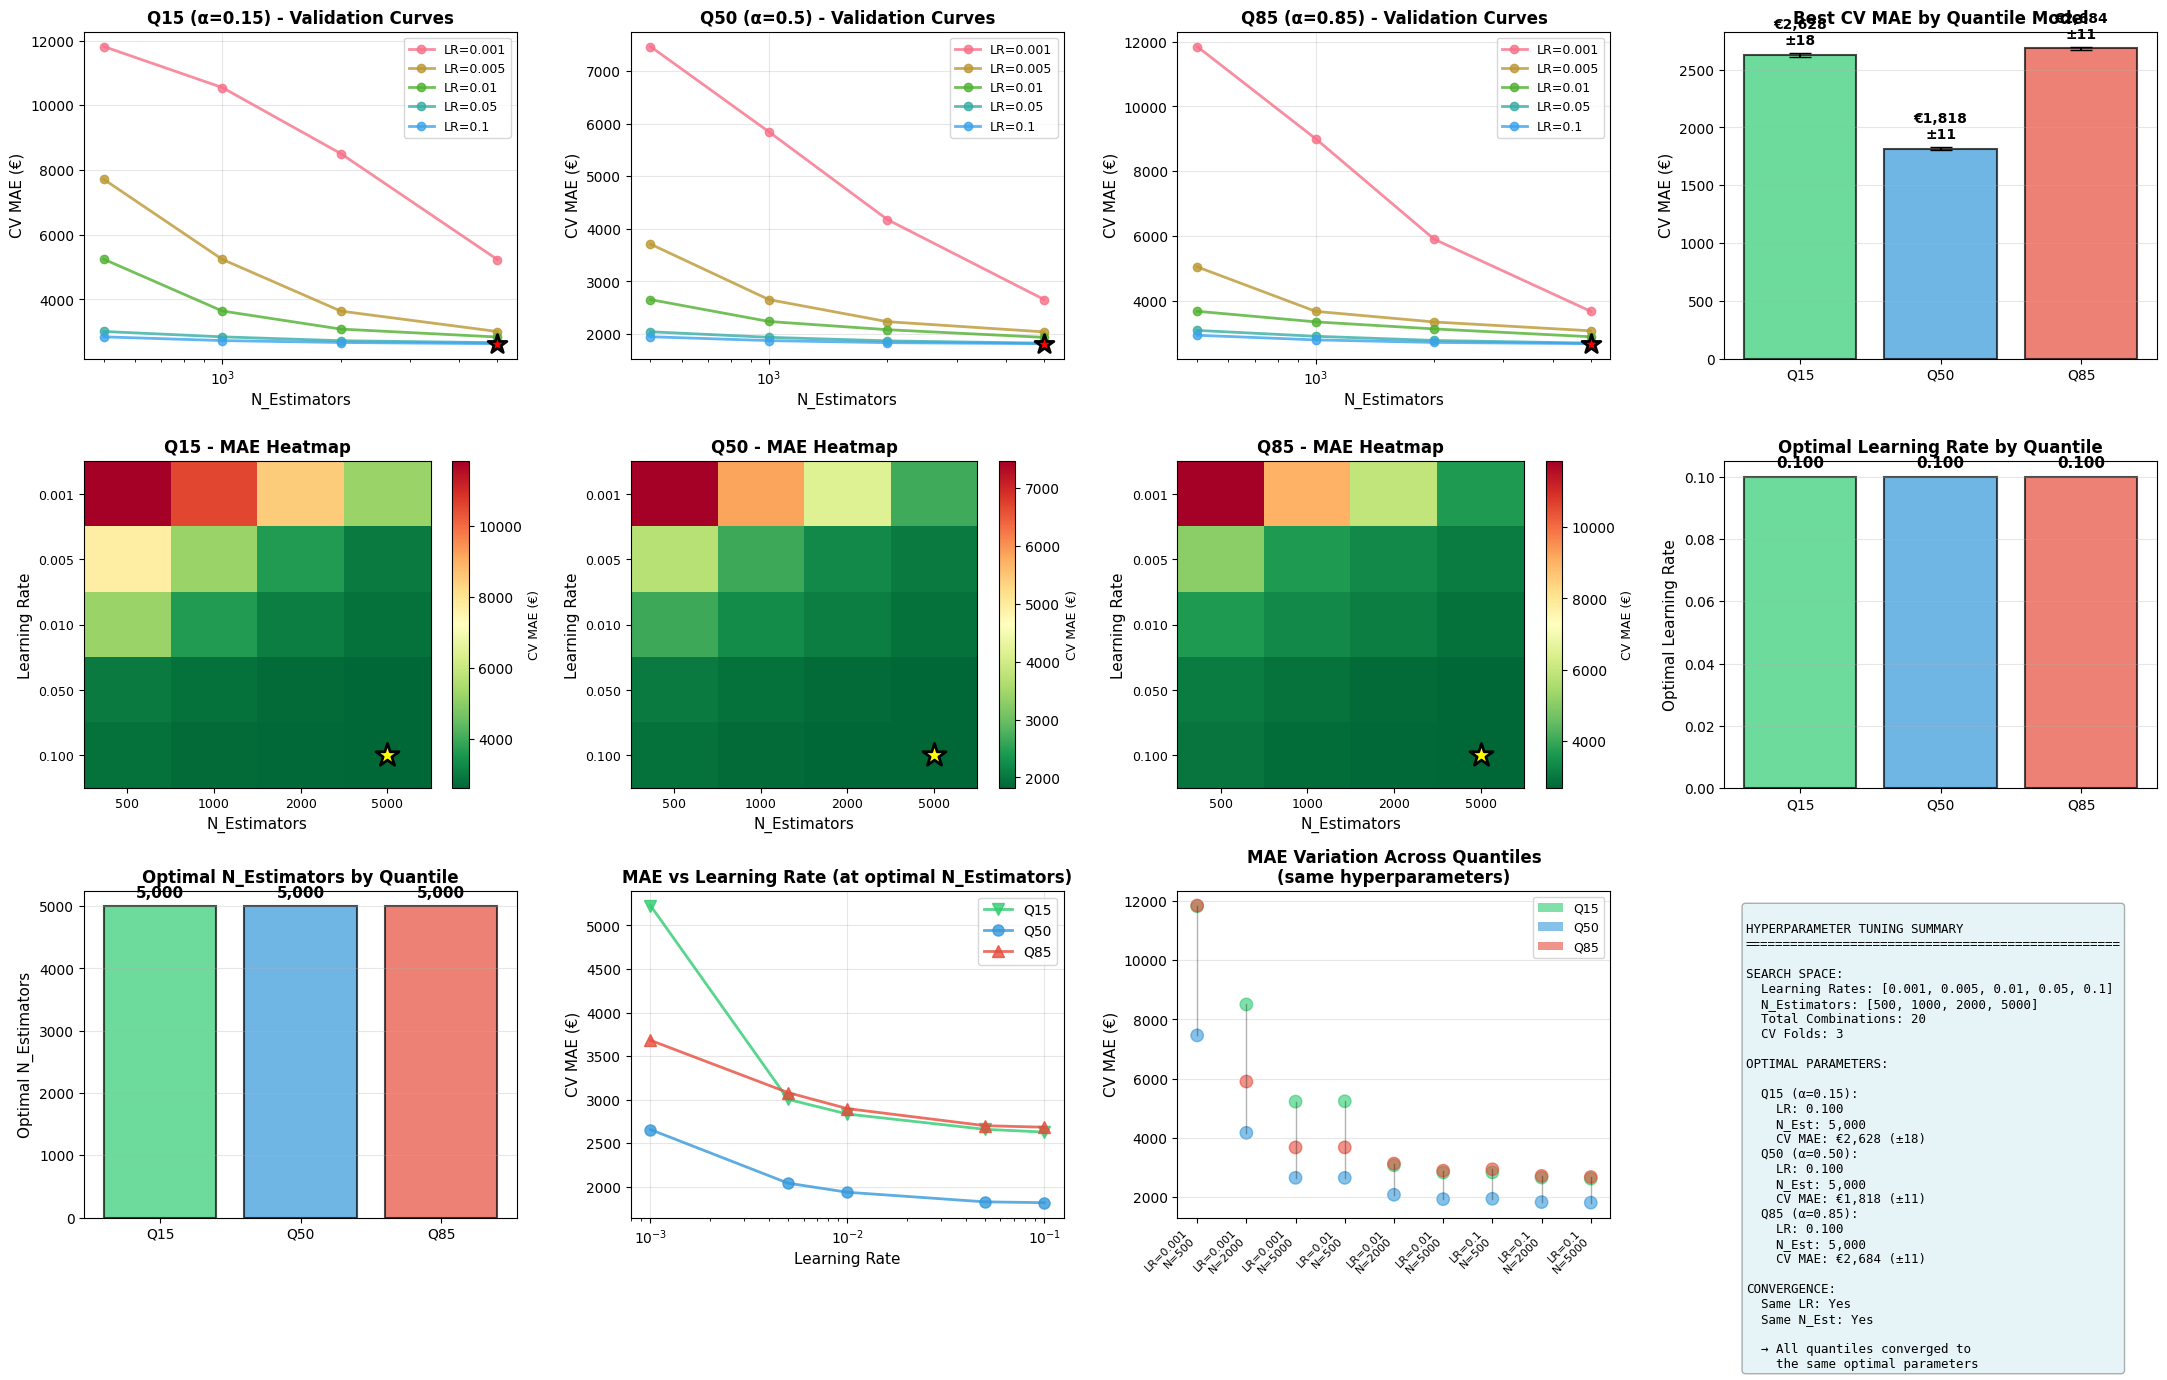


✓ Hyperparameter tuning visualizations generated


In [54]:
# ============================================================================
# VISUALIZATION: HYPERPARAMETER TUNING RESULTS
# ============================================================================
print("\n" + "=" * 80)
print("GENERATING HYPERPARAMETER TUNING VISUALIZATIONS")
print("=" * 80)

fig = plt.figure(figsize=(22, 14))

# Color scheme for quantiles
colors_q = {'Q15': '#2ecc71', 'Q50': '#3498db', 'Q85': '#e74c3c'}
markers_q = {'Q15': 'v', 'Q50': 'o', 'Q85': '^'}

# ============================================================================
# 1-3. Validation Curves: MAE vs N_Estimators for each Learning Rate
# ============================================================================
for plot_idx, quantile_name in enumerate(['Q15', 'Q50', 'Q85'], 1):
    ax = plt.subplot(3, 4, plot_idx)
    
    df_q = results_dfs[quantile_name]
    
    for lr in param_grid['learning_rate']:
        df_lr = df_q[df_q['learning_rate'] == lr]
        df_lr = df_lr.sort_values('n_estimators')
        
        ax.plot(df_lr['n_estimators'], df_lr['mae'], 
                marker='o', linewidth=2, markersize=6,
                label=f'LR={lr}', alpha=0.8)
    
    ax.set_xlabel('N_Estimators', fontsize=11)
    ax.set_ylabel('CV MAE (€)', fontsize=11)
    ax.set_title(f'{quantile_name} (α={quantiles[quantile_name]}) - Validation Curves', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    
    # Mark best point
    best = best_params[quantile_name]
    ax.scatter([best['n_estimators']], [best['mae']], 
              s=200, marker='*', color='red', edgecolors='black', 
              linewidths=2, zorder=5, label='Best')

# ============================================================================
# 4. Comparison: Best MAE Across Quantiles
# ============================================================================
ax4 = plt.subplot(3, 4, 4)
quantile_names = list(quantiles.keys())
maes = [best_params[q]['mae'] for q in quantile_names]
stds = [best_params[q]['mae_std'] for q in quantile_names]
colors_bars = [colors_q[q] for q in quantile_names]

bars = ax4.bar(quantile_names, maes, yerr=stds, capsize=8, 
               color=colors_bars, alpha=0.7, edgecolor='black', linewidth=1.5)

for i, (mae, std) in enumerate(zip(maes, stds)):
    ax4.text(i, mae + std + 50, f'€{mae:,.0f}\n±{std:,.0f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax4.set_ylabel('CV MAE (€)', fontsize=11)
ax4.set_title('Best CV MAE by Quantile Model', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# ============================================================================
# 5-7. Heatmaps: MAE by LR and N_Estimators for each Quantile
# ============================================================================
for plot_idx, quantile_name in enumerate(['Q15', 'Q50', 'Q85'], 5):
    ax = plt.subplot(3, 4, plot_idx)
    
    df_q = results_dfs[quantile_name]
    
    # Create pivot table
    pivot = df_q.pivot(index='learning_rate', columns='n_estimators', values='mae')
    
    # Plot heatmap
    im = ax.imshow(pivot.values, cmap='RdYlGn_r', aspect='auto')
    
    # Set ticks
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_yticks(range(len(pivot.index)))
    ax.set_xticklabels(pivot.columns, fontsize=9)
    ax.set_yticklabels([f'{lr:.3f}' for lr in pivot.index], fontsize=9)
    
    ax.set_xlabel('N_Estimators', fontsize=11)
    ax.set_ylabel('Learning Rate', fontsize=11)
    ax.set_title(f'{quantile_name} - MAE Heatmap', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('CV MAE (€)', fontsize=9)
    
    # Mark best combination
    best = best_params[quantile_name]
    best_row = list(pivot.index).index(best['learning_rate'])
    best_col = list(pivot.columns).index(best['n_estimators'])
    ax.scatter([best_col], [best_row], s=300, marker='*', 
              color='yellow', edgecolors='black', linewidths=2, zorder=5)

# ============================================================================
# 8. Comparison: Optimal Learning Rate Across Quantiles
# ============================================================================
ax8 = plt.subplot(3, 4, 8)
lrs = [best_params[q]['learning_rate'] for q in quantile_names]
colors_bars = [colors_q[q] for q in quantile_names]

bars = ax8.bar(quantile_names, lrs, color=colors_bars, alpha=0.7, 
              edgecolor='black', linewidth=1.5)

for i, lr in enumerate(lrs):
    ax8.text(i, lr + 0.002, f'{lr:.3f}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax8.set_ylabel('Optimal Learning Rate', fontsize=11)
ax8.set_title('Optimal Learning Rate by Quantile', fontsize=12, fontweight='bold')
ax8.grid(True, alpha=0.3, axis='y')

# ============================================================================
# 9. Comparison: Optimal N_Estimators Across Quantiles
# ============================================================================
ax9 = plt.subplot(3, 4, 9)
n_ests = [best_params[q]['n_estimators'] for q in quantile_names]
colors_bars = [colors_q[q] for q in quantile_names]

bars = ax9.bar(quantile_names, n_ests, color=colors_bars, alpha=0.7, 
              edgecolor='black', linewidth=1.5)

for i, n_est in enumerate(n_ests):
    ax9.text(i, n_est + 100, f'{n_est:,}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax9.set_ylabel('Optimal N_Estimators', fontsize=11)
ax9.set_title('Optimal N_Estimators by Quantile', fontsize=12, fontweight='bold')
ax9.grid(True, alpha=0.3, axis='y')

# ============================================================================
# 10. MAE vs Learning Rate (for best N_Estimators)
# ============================================================================
ax10 = plt.subplot(3, 4, 10)

for quantile_name in quantile_names:
    df_q = results_dfs[quantile_name]
    best_n_est = best_params[quantile_name]['n_estimators']
    
    df_best_n = df_q[df_q['n_estimators'] == best_n_est].sort_values('learning_rate')
    
    ax10.plot(df_best_n['learning_rate'], df_best_n['mae'], 
             marker=markers_q[quantile_name], linewidth=2, markersize=8,
             label=quantile_name, color=colors_q[quantile_name], alpha=0.8)

ax10.set_xlabel('Learning Rate', fontsize=11)
ax10.set_ylabel('CV MAE (€)', fontsize=11)
ax10.set_title('MAE vs Learning Rate (at optimal N_Estimators)', 
              fontsize=12, fontweight='bold')
ax10.legend(fontsize=10)
ax10.grid(True, alpha=0.3)
ax10.set_xscale('log')

# ============================================================================
# 11. Parameter Convergence: Do quantiles need different parameters?
# ============================================================================
ax11 = plt.subplot(3, 4, 11)

# For each parameter combination, plot MAE for all three quantiles
sample_combos = []
for lr in [0.001, 0.01, 0.1]:
    for n_est in [500, 2000, 5000]:
        maes_combo = []
        for q_name in quantile_names:
            df_q = results_dfs[q_name]
            mae_val = df_q[(df_q['learning_rate'] == lr) & 
                          (df_q['n_estimators'] == n_est)]['mae'].values[0]
            maes_combo.append(mae_val)
        sample_combos.append((lr, n_est, maes_combo))

# Plot scatter showing spread of MAE across quantiles for each combo
x_pos = np.arange(len(sample_combos))
for i, (lr, n_est, maes) in enumerate(sample_combos):
    ax11.scatter([i]*3, maes, s=80, alpha=0.6, 
                color=[colors_q[q] for q in quantile_names])
    ax11.plot([i]*2, [min(maes), max(maes)], 'k-', alpha=0.3, linewidth=1)

ax11.set_xticks(x_pos)
ax11.set_xticklabels([f'LR={lr}\nN={n_est}' for lr, n_est, _ in sample_combos], 
                     fontsize=8, rotation=45, ha='right')
ax11.set_ylabel('CV MAE (€)', fontsize=11)
ax11.set_title('MAE Variation Across Quantiles\n(same hyperparameters)', 
              fontsize=12, fontweight='bold')
ax11.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors_q[q], label=q, alpha=0.6) 
                  for q in quantile_names]
ax11.legend(handles=legend_elements, fontsize=9, loc='upper right')

# ============================================================================
# 12. Summary Statistics Table
# ============================================================================
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')

summary_text = f"""
HYPERPARAMETER TUNING SUMMARY
{'=' * 50}

SEARCH SPACE:
  Learning Rates: {param_grid['learning_rate']}
  N_Estimators: {param_grid['n_estimators']}
  Total Combinations: {len(param_grid['learning_rate']) * len(param_grid['n_estimators'])}
  CV Folds: 3

OPTIMAL PARAMETERS:
"""

for q_name in quantile_names:
    params = best_params[q_name]
    summary_text += f"\n  {q_name} (α={quantiles[q_name]:.2f}):"
    summary_text += f"\n    LR: {params['learning_rate']:.3f}"
    summary_text += f"\n    N_Est: {params['n_estimators']:,}"
    summary_text += f"\n    CV MAE: €{params['mae']:,.0f} (±{params['mae_std']:,.0f})"

# Check if all quantiles converged to same parameters
same_lr = len(set(best_params[q]['learning_rate'] for q in quantile_names)) == 1
same_n_est = len(set(best_params[q]['n_estimators'] for q in quantile_names)) == 1

summary_text += f"\n\nCONVERGENCE:"
summary_text += f"\n  Same LR: {'Yes' if same_lr else 'No'}"
summary_text += f"\n  Same N_Est: {'Yes' if same_n_est else 'No'}"

if not (same_lr and same_n_est):
    summary_text += f"\n\n  → Different quantiles prefer"
    summary_text += f"\n    different hyperparameters"
else:
    summary_text += f"\n\n  → All quantiles converged to"
    summary_text += f"\n    the same optimal parameters"

ax12.text(0.05, 0.95, summary_text, transform=ax12.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n✓ Hyperparameter tuning visualizations generated")
print("=" * 80)

In [55]:
# ============================================================================
# EXPORT BEST PARAMETERS AND KEY INSIGHTS
# ============================================================================
print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING - KEY INSIGHTS")
print("=" * 80)

# Create summary DataFrame for easy export
summary_df = pd.DataFrame({
    'Quantile': list(quantiles.keys()),
    'Alpha': [quantiles[q] for q in quantiles.keys()],
    'Best_LR': [best_params[q]['learning_rate'] for q in quantiles.keys()],
    'Best_N_Est': [best_params[q]['n_estimators'] for q in quantiles.keys()],
    'CV_MAE': [best_params[q]['mae'] for q in quantiles.keys()],
    'CV_MAE_Std': [best_params[q]['mae_std'] for q in quantiles.keys()]
})

print("\n📊 BEST PARAMETERS SUMMARY TABLE:")
print("-" * 80)
print(summary_df.to_string(index=False))

# Analyze parameter consistency
print("\n\n🔍 ANALYSIS:")
print("-" * 80)

lrs_unique = summary_df['Best_LR'].nunique()
n_ests_unique = summary_df['Best_N_Est'].nunique()

print(f"\n1. Parameter Consistency Across Quantiles:")
print(f"   - Learning Rate: {lrs_unique} unique value(s)")
print(f"   - N_Estimators: {n_ests_unique} unique value(s)")

if lrs_unique == 1 and n_ests_unique == 1:
    print(f"\n   ✓ All three quantile models converged to the SAME optimal parameters!")
    print(f"     This suggests the optimal hyperparameters are robust across quantiles.")
    print(f"\n   Recommended parameters for all quantiles:")
    print(f"     - learning_rate = {summary_df['Best_LR'].iloc[0]}")
    print(f"     - n_estimators = {summary_df['Best_N_Est'].iloc[0]}")
else:
    print(f"\n   ⚠️  Different quantiles prefer DIFFERENT parameters!")
    print(f"     You should use quantile-specific parameters for best performance.")

# Compare with initial parameters
initial_lr = 0.05
initial_n_est = 500

print(f"\n2. Comparison with Initial Parameters (LR={initial_lr}, N_Est={initial_n_est}):")
print(f"   Model      Initial MAE   Tuned MAE    Improvement")
print(f"   " + "-" * 60)

for q_name in quantiles.keys():
    # Find initial parameters performance
    df_q = results_dfs[q_name]
    initial_mae = df_q[(df_q['learning_rate'] == initial_lr) & 
                       (df_q['n_estimators'] == initial_n_est)]['mae'].values
    
    if len(initial_mae) > 0:
        initial_mae = initial_mae[0]
        tuned_mae = best_params[q_name]['mae']
        improvement = 100 * (initial_mae - tuned_mae) / initial_mae
        print(f"   {q_name:<10} €{initial_mae:>10,.0f}   €{tuned_mae:>10,.0f}   {improvement:>+6.2f}%")

# MAE spread analysis
mae_values = [best_params[q]['mae'] for q in quantiles.keys()]
mae_spread = max(mae_values) - min(mae_values)
mae_avg = np.mean(mae_values)

print(f"\n3. Performance Variation Across Quantiles:")
print(f"   - Average MAE: €{mae_avg:,.0f}")
print(f"   - MAE Spread: €{mae_spread:,.0f}")
print(f"   - Relative Spread: {100*mae_spread/mae_avg:.2f}%")

if mae_spread / mae_avg < 0.10:
    print(f"\n   ✓ Low variation (<10%) - all quantiles perform similarly well")
else:
    print(f"\n   ⚠️  Notable variation - some quantiles are harder to predict")

# Cross-validation stability
print(f"\n4. Cross-Validation Stability:")
for q_name in quantiles.keys():
    mae = best_params[q_name]['mae']
    std = best_params[q_name]['mae_std']
    cv_coef = 100 * std / mae
    print(f"   {q_name}: CV={cv_coef:.2f}% (€{mae:,.0f} ±{std:,.0f})")
    
avg_cv_coef = np.mean([100 * best_params[q]['mae_std'] / best_params[q]['mae'] 
                        for q in quantiles.keys()])
if avg_cv_coef < 5:
    print(f"\n   ✓ Excellent stability (CV < 5%) - parameters are reliable")
elif avg_cv_coef < 10:
    print(f"\n   ✓ Good stability (CV < 10%) - parameters are reasonably reliable")
else:
    print(f"\n   ⚠️  Higher variability (CV > 10%) - consider more CV folds")

print("\n" + "=" * 80)
print("✓ HYPERPARAMETER TUNING ANALYSIS COMPLETE")
print("=" * 80)

# Display the best parameters dictionary for easy reference
print("\n💾 BEST PARAMETERS (ready to use):")
print("-" * 80)
print("best_params = {")
for q_name in quantiles.keys():
    params = best_params[q_name]
    print(f"    '{q_name}': {{'learning_rate': {params['learning_rate']}, "
          f"'n_estimators': {params['n_estimators']}}},")
print("}")
print("\n" + "=" * 80)


HYPERPARAMETER TUNING - KEY INSIGHTS

📊 BEST PARAMETERS SUMMARY TABLE:
--------------------------------------------------------------------------------
Quantile  Alpha  Best_LR  Best_N_Est      CV_MAE  CV_MAE_Std
     Q15   0.15      0.1        5000 2628.322656   17.656942
     Q50   0.50      0.1        5000 1817.656940   10.621641
     Q85   0.85      0.1        5000 2683.973111   10.739146


🔍 ANALYSIS:
--------------------------------------------------------------------------------

1. Parameter Consistency Across Quantiles:
   - Learning Rate: 1 unique value(s)
   - N_Estimators: 1 unique value(s)

   ✓ All three quantile models converged to the SAME optimal parameters!
     This suggests the optimal hyperparameters are robust across quantiles.

   Recommended parameters for all quantiles:
     - learning_rate = 0.1
     - n_estimators = 5000

2. Comparison with Initial Parameters (LR=0.05, N_Est=500):
   Model      Initial MAE   Tuned MAE    Improvement
   ----------------------